# Identifikasi Audio "Buka Tutup"  

Mengimplementasikan sistem klasifikasi suara untuk mengenali perintah "buka" dan "tutup" dari **speaker terdaftar** dan menolak speaker lain.  

Pipeline ini menggunakan ekstraksi fitur statistik time-series, spektral, dan MFCC untuk melatih model Random Forest.  

## Data Understanding  

### Import Libraries  

Mengimpor semua library yang diperlukan untuk pemrosesan audio (`librosa`), analisis data (`pandas`, `numpy`), machine learning (`sklearn`), dan visualisasi (`matplotlib`, `seaborn`).

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import scipy
import os
import shutil
import json
from tqdm.notebook import tqdm
import glob
import joblib
import IPython.display as ipd
import warnings

# Mengatur agar warning tidak ditampilkan
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

print("Libraries imported successfully!")

Libraries imported successfully!


### Eksplorasi & Audit Dataset  

Pada langkah ini, kita akan mendefinisikan path ke folder dataset dan melakukan audit awal pada struktur data.  

Kode ini akan:  
1.  Menemukan dan mendaftar semua speaker (sub-folder).
2.  Menghitung jumlah file audio (`.wav`) untuk setiap speaker dan setiap label ('buka'/'tutup'). Ini penting untuk memeriksa keseimbangan data.
3.  Memuat **satu file sampel** dengan *sample rate* (SR) aslinya (`sr=None`) untuk memeriksa properti mentah audio, seperti SR asli, durasi, dan rentang amplitudo.

In [28]:
print("ANALISIS STRUKTUR DATASET")
print("="*50)

DATASET_PATH = r"C:\Github\psd\dataset"
print(f"Dataset Path: {DATASET_PATH}")

# Cari semua subfolder (speaker)
speakers = [spk for spk in os.listdir(DATASET_PATH)
            if os.path.isdir(os.path.join(DATASET_PATH, spk))]

print(f"\nJumlah Speaker: {len(speakers)}")
print("Daftar Speaker:", speakers)

total_files = 0

print("\nSTATISTIK DATASET:")
for spk in speakers:
    spk_path = os.path.join(DATASET_PATH, spk, "buka")
    wav_files_buka = glob.glob(os.path.join(spk_path, "*.wav"))
    buka_count = len(wav_files_buka)

    spk_path_tutup = os.path.join(DATASET_PATH, spk, "tutup")
    wav_files_tutup = glob.glob(os.path.join(spk_path_tutup, "*.wav"))
    tutup_count = len(wav_files_tutup)

    total = buka_count + tutup_count
    total_files += total

    print(f"\nSpeaker: {spk}")
    print(f"   - File 'Buka' : {buka_count}")
    print(f"   - File 'Tutup': {tutup_count}")
    print(f"   - Total       : {total}")

print(f"\nTOTAL SEMUA FILE AUDIO: {total_files}")

# Sample informasi file
print("\nSAMPLE INFORMASI FILE:")
sample_file = None
for spk in speakers:
    files = glob.glob(os.path.join(DATASET_PATH, spk, "buka", "*.wav")) + \
            glob.glob(os.path.join(DATASET_PATH, spk, "tutup", "*.wav"))
    if files:
        sample_file = files[0]
        break

if sample_file:
    audio, sr = librosa.load(sample_file, sr=None)
    duration = len(audio) / sr

    print(f"   File Sample: {os.path.basename(sample_file)}")
    print(f"   Speaker    : {spk}")
    print(f"\nINFORMASI AUDIO SAMPLE:")
    print(f"   - Sample Rate : {sr} Hz")
    print(f"   - Durasi      : {duration:.2f} detik")
    print(f"   - Jumlah Sampel: {len(audio)}")
    print(f"   - Range nilai : [{audio.min():.4f}, {audio.max():.4f}]")
else:
    print("   Tidak ada file ditemukan!")

print("\nDataset exploration completed!")

ANALISIS STRUKTUR DATASET
Dataset Path: C:\Github\psd\dataset

Jumlah Speaker: 2
Daftar Speaker: ['aqbil', 'reni']

STATISTIK DATASET:

Speaker: aqbil
   - File 'Buka' : 50
   - File 'Tutup': 50
   - Total       : 100

Speaker: reni
   - File 'Buka' : 50
   - File 'Tutup': 50
   - Total       : 100

TOTAL SEMUA FILE AUDIO: 200

SAMPLE INFORMASI FILE:
   File Sample: buka_0.wav
   Speaker    : aqbil

INFORMASI AUDIO SAMPLE:
   - Sample Rate : 48000 Hz
   - Durasi      : 1.40 detik
   - Jumlah Sampel: 67096
   - Range nilai : [-0.2993, 0.4257]

Dataset exploration completed!


### Distribusi Dataset  

Langkah krusial dalam *Data Understanding* adalah memvisualisasikan distribusi data. Kita perlu memeriksa keseimbangan (balance) data antar kelas.  

Kode ini akan:  
1.  Mengagregasi jumlah file untuk label `buka` dan `tutup` dari semua speaker.
2.  Membuat tabel ringkasan jumlah file per speaker.
3.  Membuat **dua plot**:
    * **Bar Plot Total:** Perbandingan total file 'buka' vs 'tutup' di seluruh dataset.
    * **Bar Plot Per Speaker:** Perbandingan file 'buka' vs 'tutup' yang dipecah per speaker.  

Melihat ini membantu kita mengidentifikasi jika ada *class imbalance* (misalnya, terlalu banyak file 'buka' daripada 'tutup') yang dapat memengaruhi performa model.


VISUALISASI DISTRIBUSI DATASET

Jumlah file per speaker:
  Speaker  Buka  Tutup
0   aqbil    50     50
1    reni    50     50

TOTAL KESELURUHAN DATASET:
   - Total File 'Buka' : 100 (50.00%)
   - Total File 'Tutup': 100 (50.00%)
   - Total File       : 200


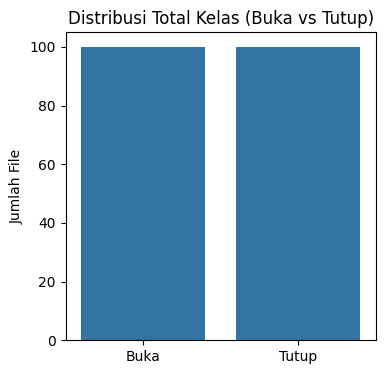

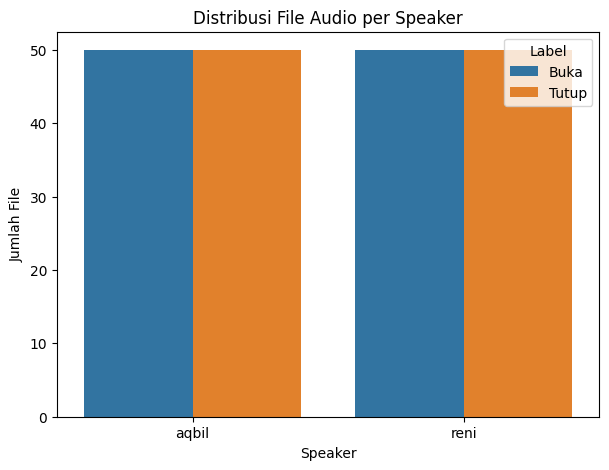

In [29]:
print("\nVISUALISASI DISTRIBUSI DATASET")
print("="*50)

DATASET_PATH = "dataset" 

if not os.path.isdir(DATASET_PATH):
    print(f"Error: Folder '{DATASET_PATH}' tidak ditemukan.")
    print("Pastikan folder 'dataset' berada di lokasi yang sama dengan file notebook Anda.")
else:
    speakers = [spk for spk in os.listdir(DATASET_PATH)
                if os.path.isdir(os.path.join(DATASET_PATH, spk))]

    data_list = []
    for spk in speakers:
        spk_path_buka = os.path.join(DATASET_PATH, spk, "buka")
        spk_path_tutup = os.path.join(DATASET_PATH, spk, "tutup")
        buka_files = glob.glob(os.path.join(spk_path_buka, "*.wav"))
        tutup_files = glob.glob(os.path.join(spk_path_tutup, "*.wav"))

        data_list.append({
            "Speaker": spk,
            "Buka": len(buka_files),
            "Tutup": len(tutup_files)
        })

    df_counts = pd.DataFrame(data_list)
    print("\nJumlah file per speaker:")
    print(df_counts)

    if not df_counts.empty:
        total_buka = df_counts['Buka'].sum()
        total_tutup = df_counts['Tutup'].sum()
        total_keseluruhan = total_buka + total_tutup 
        
        if total_keseluruhan > 0:
            print(f"\nTOTAL KESELURUHAN DATASET:")
            print(f"   - Total File 'Buka' : {total_buka} ({total_buka/total_keseluruhan*100:.2f}%)")
            print(f"   - Total File 'Tutup': {total_tutup} ({total_tutup/total_keseluruhan*100:.2f}%)")
            print(f"   - Total File       : {total_keseluruhan}")

            # Visualisasi Total
            plt.figure(figsize=(4, 4))
            sns.barplot(x=['Buka', 'Tutup'], y=[total_buka, total_tutup])
            plt.title("Distribusi Total Kelas (Buka vs Tutup)")
            plt.ylabel("Jumlah File")
            plt.show()
        else:
            print("Tidak ada file .wav yang ditemukan.")

    df_plot = df_counts.melt(id_vars='Speaker', var_name='Label', value_name='Jumlah')
    
    plt.figure(figsize=(7,5))
    sns.barplot(data=df_plot, x='Speaker', y='Jumlah', hue='Label')
    plt.title("Distribusi File Audio per Speaker")
    plt.ylabel("Jumlah File")
    plt.xlabel("Speaker")
    plt.show()

### Visualisasi Waveform Audio  

Visualisasi waveform dilakukan untuk membandingkan karakteristik sinyal mentah antara kelas **buka** dan **tutup**. Waveform menunjukkan perubahan amplitudo (kekerasan suara) terhadap waktu.  

Kita akan memuat satu sampel acak untuk setiap kelas dan memplotnya untuk melihat apakah ada perbedaan pola yang jelas secara visual.  


VISUALISASI WAVEFORM AUDIO


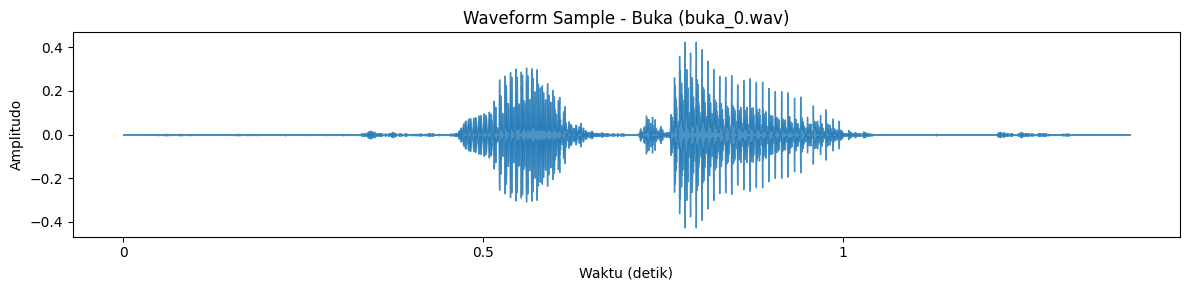

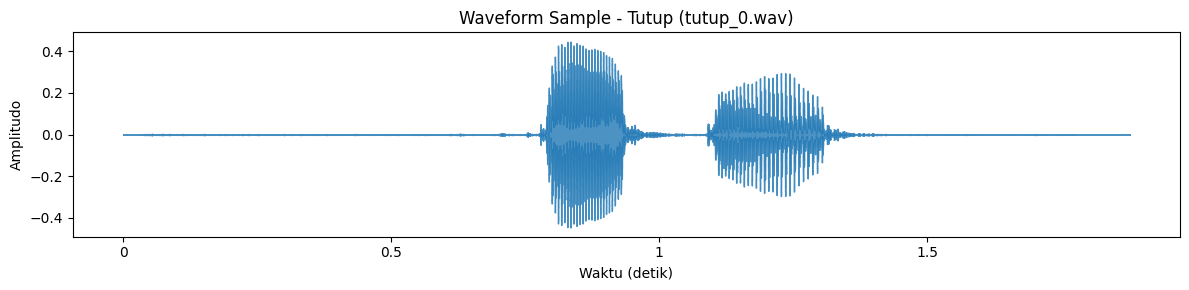

In [30]:
print("\nVISUALISASI WAVEFORM AUDIO")
print("="*50)

def plot_waveform(file_path, title):
    """Memuat file audio dan memplot waveform-nya."""
    try:
        y, sr = librosa.load(file_path, sr=None) 
        plt.figure(figsize=(12, 3))
        librosa.display.waveshow(y, sr=sr, alpha=0.8)
        plt.title(title)
        plt.xlabel("Waktu (detik)")
        plt.ylabel("Amplitudo")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error memuat file {file_path}: {e}")

if 'DATASET_PATH' in locals() and 'speakers' in locals():
    buka_sample = None
    tutup_sample = None

    for spk in speakers:
        if buka_sample is None:
            files_buka = glob.glob(os.path.join(DATASET_PATH, spk, "buka", "*.wav"))
            if files_buka:
                buka_sample = files_buka[0] 
        
        if tutup_sample is None:
            files_tutup = glob.glob(os.path.join(DATASET_PATH, spk, "tutup", "*.wav"))
            if files_tutup:
                tutup_sample = files_tutup[0] 
        
        if buka_sample and tutup_sample:
            break

    if buka_sample:
        plot_waveform(buka_sample, f"Waveform Sample - Buka ({os.path.basename(buka_sample)})")
    else:
        print("Tidak ditemukan sample untuk kelas Buka")

    if tutup_sample:
        plot_waveform(tutup_sample, f"Waveform Sample - Tutup ({os.path.basename(tutup_sample)})")
    else:
        print("Tidak ditemukan sample untuk kelas Tutup")
else:
    print("Error: Variabel 'DATASET_PATH' atau 'speakers' tidak terdefinisi.")
    print("Pastikan Anda sudah menjalankan sel 'VISUALISASI DISTRIBUSI DATASET' sebelumnya.")

### Preview Audio Sampel  

Setelah memvisualisasikan data secara kuantitatif, langkah selanjutnya adalah validasi kualitatif dengan mendengarkan langsung sampel audio.  

Kode ini akan memutar file `buka_sample` dan `tutup_sample` yang kita temukan di langkah sebelumnya. Ini membantu kita memastikan bahwa:   
1.  Label data sudah benar (suara "buka" memang berlabel "buka").
2.  Kualitas audio baik (tidak ada korupsi file atau noise yang ekstrem).

In [31]:
print("\nPREVIEW SAMPLE AUDIO")
print("="*50)

if 'buka_sample' in locals() and buka_sample:
    print(f"\nContoh Audio BUKA: {os.path.basename(buka_sample)}")
    display(ipd.Audio(buka_sample))
else:
    print("Sample audio untuk 'Buka' tidak ditemukan atau variabel belum terdefinisi.")

if 'tutup_sample' in locals() and tutup_sample:
    print(f"\nContoh Audio TUTUP: {os.path.basename(tutup_sample)}")
    display(ipd.Audio(tutup_sample))
else:
    print("Sample audio untuk 'Tutup' tidak ditemukan atau variabel belum terdefinisi.")


PREVIEW SAMPLE AUDIO

Contoh Audio BUKA: buka_0.wav



Contoh Audio TUTUP: tutup_0.wav


### Analisis Durasi dan Sample Rate  

Langkah ini menganalisis metadata teknis dari semua file audio di dataset.  

1.  **Analisis Sample Rate (SR):** Kita perlu memeriksa apakah semua file memiliki sample rate yang sama. Jika SR bervariasi (misal, 44100 Hz dan 48000 Hz), fitur yang diekstrak tidak akan konsisten. Ini akan **memvalidasi keputusan** kita untuk menstandarisasi semua audio ke `TARGET_SR` (22050 Hz).  
2.  **Analisis Durasi:** Kita akan melihat statistik (`.describe()`) dan distribusi durasi audio. Ini membantu kita memahami apakah ada file yang sangat pendek atau sangat panjang, dan membandingkan durasi antara kelas `buka` dan `tutup`.

-Analisis Karakteristik Audio


Menganalisis metadata file:   0%|          | 0/200 [00:00<?, ?it/s]


--- Analisis Sample Rate Asli ---
Distribusi Sample Rate Asli Ditemukan:
SampleRate
48000    200
Name: count, dtype: int64

KEPUTUSAN: Sample Rate seragam (GLOBAL_SR) ditetapkan ke: 22050 Hz
Semua audio akan di-resample ke nilai ini saat Feature Engineering.

--- Analisis Durasi ---
Statistik Durasi (dalam detik) untuk semua file:
count    200.000000
mean       1.720067
std        0.303926
min        1.073500
25%        1.513500
50%        1.693500
75%        1.914583
max        2.977833
Name: Duration, dtype: float64


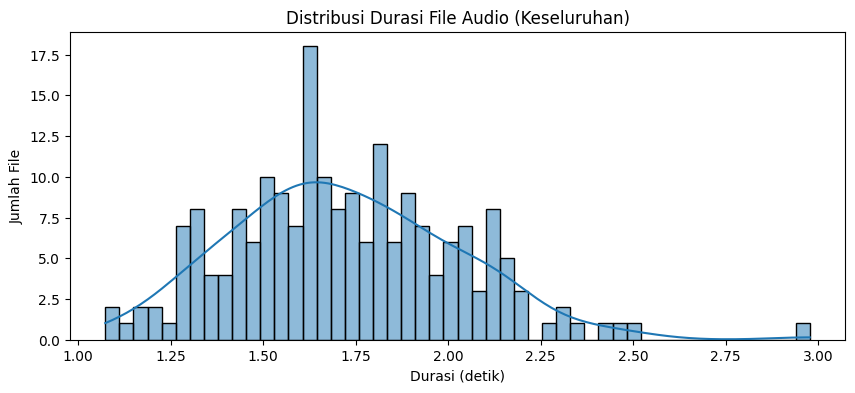

In [32]:
print("-Analisis Karakteristik Audio")
print("="*50)

def get_audio_metadata(file_path):
    """Mengekstrak metadata dasar dari satu file audio."""
    try:
        y, sr = librosa.load(file_path, sr=None) 
        duration = librosa.get_duration(y=y, sr=sr)
        return sr, duration
    except Exception as e:
        return None, None

if 'DATASET_PATH' not in locals():
    DATASET_PATH = "dataset"
    
metadata_list = []
all_files = glob.glob(os.path.join(DATASET_PATH, "**", "*.wav"), recursive=True)

for file in tqdm(all_files, desc="Menganalisis metadata file"):
    sr, duration = get_audio_metadata(file)
    if sr is not None:
        # Dapatkan label dari path file untuk visualisasi nanti
        parts = file.split(os.sep)
        label = parts[-2] # 'buka' atau 'tutup'
        
        metadata_list.append({
            "SampleRate": sr,
            "Duration": duration,
            "Label": label, 
            "File": file
        })

# Buat DataFrame dari hasil analisis
df_meta = pd.DataFrame(metadata_list)

if not df_meta.empty:
    # Analisis Sample Rate
    print("\n" + "="*30)
    print("--- Analisis Sample Rate Asli ---")
    # Hitung jumlah file untuk setiap SR yang ditemukan
    sr_counts = df_meta['SampleRate'].value_counts()
    print(f"Distribusi Sample Rate Asli Ditemukan:\n{sr_counts}")
    
    # KEPUTUSAN PREPROCESSING
    GLOBAL_SR = 22050
    print(f"\nKEPUTUSAN: Sample Rate seragam (GLOBAL_SR) ditetapkan ke: {GLOBAL_SR} Hz")
    print("Semua audio akan di-resample ke nilai ini saat Feature Engineering.")

    # Analisis Durasi
    print("\n" + "="*30)
    print("--- Analisis Durasi ---")
    print("Statistik Durasi (dalam detik) untuk semua file:")
    print(df_meta['Duration'].describe())

    # Plot Histogram Keseluruhan
    plt.figure(figsize=(10, 4))
    sns.histplot(df_meta['Duration'], bins=50, kde=True)
    plt.title("Distribusi Durasi File Audio (Keseluruhan)")
    plt.xlabel("Durasi (detik)")
    plt.ylabel("Jumlah File")
    plt.show()
else:
    print("Error: Tidak ada file audio yang ditemukan di 'df_meta'.")

#### Visualisasi Distribusi Sample Rate.

Visualisasi Distribusi Sample Rate


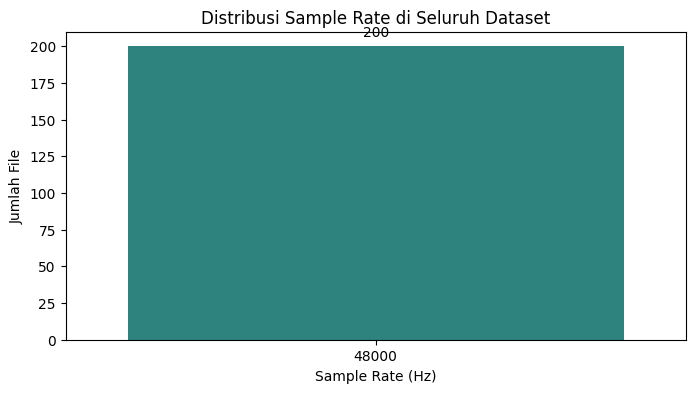

In [33]:
print("Visualisasi Distribusi Sample Rate")
print("="*50)

if 'sr_counts' in locals() and not sr_counts.empty:
    plt.figure(figsize=(8, 4))
    
    # Buat bar plot dari 'sr_counts'
    sns.barplot(x=sr_counts.index, y=sr_counts.values, palette="viridis")
    
    plt.title("Distribusi Sample Rate di Seluruh Dataset")
    plt.xlabel("Sample Rate (Hz)")
    plt.ylabel("Jumlah File")
    
    # Memberi anotasi angka di atas bar
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    
    plt.show()
else:
    print("Variabel 'sr_counts' tidak ditemukan atau kosong.")
    print("Silakan jalankan sel 'Analisis Karakteristik Audio' terlebih dahulu.")

#### Visualisasi Durasi Audio (Histogram + Per Kelas).


VISUALISASI DISTRIBUSI DURASI AUDIO


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


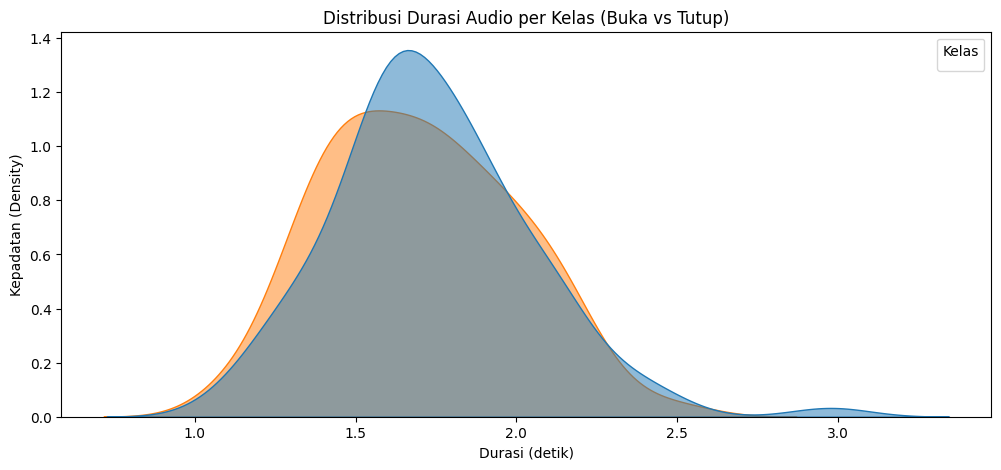

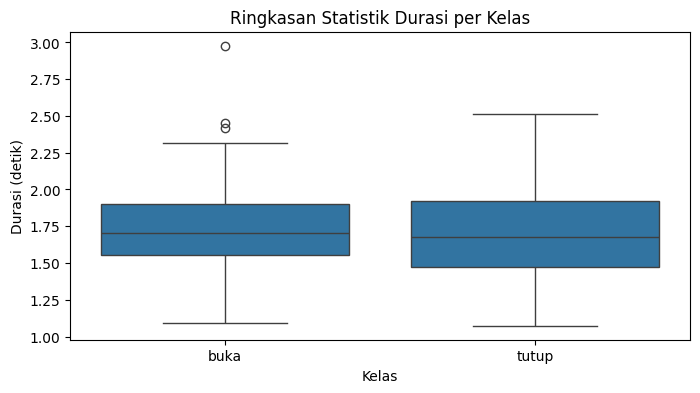

In [34]:
print("\nVISUALISASI DISTRIBUSI DURASI AUDIO")
print("="*50)

if 'df_meta' in locals() and 'Label' in df_meta.columns:
    
    # Histogram
    plt.figure(figsize=(12, 5))
    
    sns.kdeplot(data=df_meta, x='Duration', hue='Label', 
                fill=True,     
                common_norm=False,
                alpha=0.5)  
                
    plt.title('Distribusi Durasi Audio per Kelas (Buka vs Tutup)')
    plt.xlabel('Durasi (detik)')
    plt.ylabel('Kepadatan (Density)')
    plt.legend(title='Kelas')
    plt.show()

    # Box Plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_meta, x='Label', y='Duration')
    plt.title('Ringkasan Statistik Durasi per Kelas')
    plt.xlabel('Kelas')
    plt.ylabel('Durasi (detik)')
    plt.show()
    
else:
    print("Error: 'df_meta' tidak ditemukan atau tidak memiliki kolom 'Label'.")
    print("Harap jalankan sel 'Analisis Karakteristik Audio' sebelumnya.")


## Preprocessing Audio  

Pada tahap ini, kita mendemonstrasikan preprocessing untuk memastikan setiap file audio:  
1.  Memiliki **Sample Rate yang seragam** (kita tetapkan ke `TARGET_SR = 22050` Hz) melalui *resampling*.
2.  Telah **dihilangkan keheningannya** di awal dan akhir audio menggunakan *trimming* (`top_db=20`).

Standarisasi ini penting agar ekstraksi fitur statistik dapat dilakukan secara konsisten dan adil di semua file.  


In [35]:
print("Preprocessing Audio")
print("="*50)

if 'TARGET_SR' not in locals():
    TARGET_SR = 22050
    print(f"Variabel TARGET_SR tidak ditemukan, diatur ulang ke: {TARGET_SR} Hz")

if 'buka_sample' in locals() and buka_sample is not None:
    
    y, sr = librosa.load(buka_sample, sr=TARGET_SR, mono=True)
    
    # Terapkan Trimming Keheningan
    y_trimmed, index = librosa.effects.trim(y, top_db=20)
    
    # Cetak perbandingan
    print(f"\nFile Sample: {os.path.basename(buka_sample)}")
    print(f"Sample Rate (setelah resampling): {sr} Hz")
    print(f"Panjang audio asli: {len(y)} sampel ({len(y)/sr:.2f} detik)")
    print(f"Panjang audio setelah trim: {len(y_trimmed)} sampel ({len(y_trimmed)/sr:.2f} detik)")
    print(f"Total sampel keheningan dihilangkan: {len(y) - len(y_trimmed)}")

else:
    print("\nError: Variabel 'buka_sample' tidak terdefinisi.")
    print("Harap jalankan sel 'Visualisasi Wavef/orm Audio' terlebih dahulu.")

Preprocessing Audio

File Sample: buka_0.wav
Sample Rate (setelah resampling): 22050 Hz
Panjang audio asli: 30823 sampel (1.40 detik)
Panjang audio setelah trim: 12800 sampel (0.58 detik)
Total sampel keheningan dihilangkan: 18023


### Visualisasi Perbandingan Sebelum vs Sesudah preprocessing

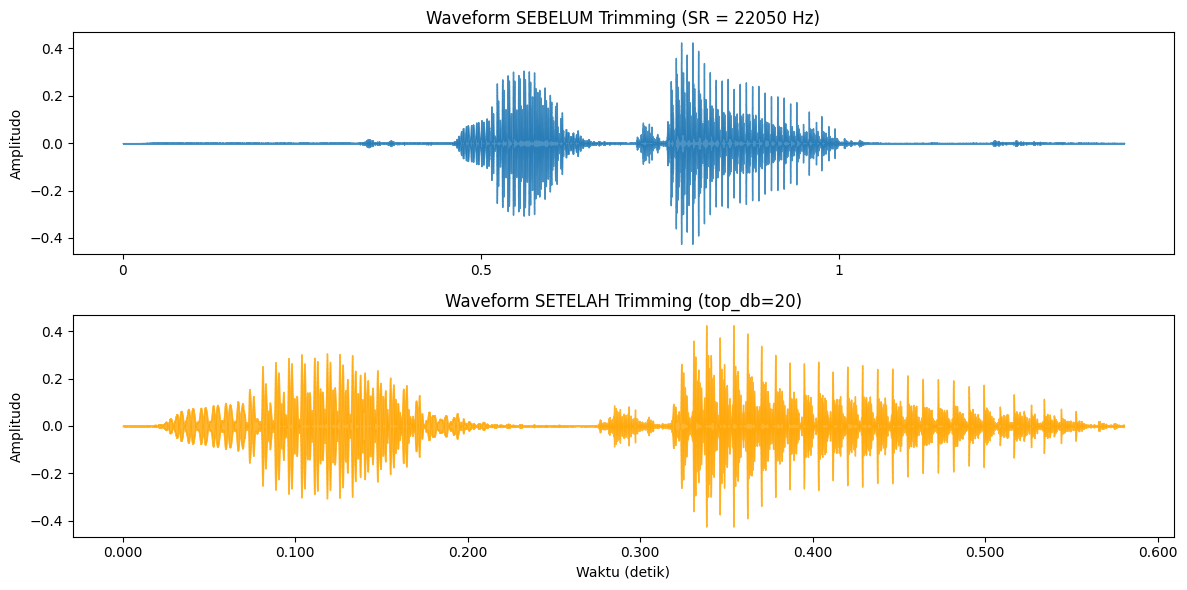


Audio SEBELUM Trimming (Hanya Resample)



Audio SETELAH Trimming


In [36]:
# Visualisasi Perbandingan
plt.figure(figsize=(12, 6))
    
# Waveform Asli (setelah resampling)
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title(f"Waveform SEBELUM Trimming (SR = {sr} Hz)")
plt.xlabel(None)
plt.ylabel("Amplitudo")
    
# Waveform Setelah Trimming
plt.subplot(2, 1, 2)
librosa.display.waveshow(y_trimmed, sr=sr, color='orange', alpha=0.8)
plt.title("Waveform SETELAH Trimming (top_db=20)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Amplitudo")

    
plt.tight_layout()
plt.show()

print("\nAudio SEBELUM Trimming (Hanya Resample)")
display(ipd.Audio(y, rate=sr))
    
print("\nAudio SETELAH Trimming")
display(ipd.Audio(y_trimmed, rate=sr))

## Ekstraksi Fitur  

Ini adalah langkah paling penting dalam pipeline kita. Kita akan menerapkan preprocessing (resample dan trim) yang telah kita demonstrasikan ke **seluruh** dataset.

In [37]:
print("Feature Extraction")
print("="*50)

if 'TARGET_SR' not in locals():
    TARGET_SR = 22050
    print(f"Variabel TARGET_SR tidak ditemukan, diatur ulang ke: {TARGET_SR} Hz")

def extract_features_pro(file_path, sr_target=TARGET_SR, n_mfcc=20):
    """
    Mengekstrak BANYAK FITUR:
    Time-Series (7), Spektral (7), dan MFCC (80).
    """
    try:
        # MEMBACA & PREPROCESSING
        y, sr = librosa.load(file_path, sr=sr_target, mono=True)
        y, _ = librosa.effects.trim(y, top_db=20)
        
        if len(y) < 1000: 
            return None

        # EKSTRAKSI FITUR
        # Fitur Time-Series (7 Fitur)
        features = {
            'mean': np.mean(y), 'std': np.std(y), 'skewness': scipy.stats.skew(y),
            'kurtosis': scipy.stats.kurtosis(y), 'iqr': scipy.stats.iqr(y),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y))
        }

        # Fitur Spektral (7 Fitur)
        S = np.abs(librosa.stft(y))
        features['spec_centroid'] = np.mean(librosa.feature.spectral_centroid(S=S))
        features['spec_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(S=S))
        features['spec_contrast'] = np.mean(librosa.feature.spectral_contrast(S=S))
        features['spec_flatness'] = np.mean(librosa.feature.spectral_flatness(S=S))
        features['spec_rolloff'] = np.mean(librosa.feature.spectral_rolloff(S=S, sr=sr))
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz)
        features['tonnetz_std'] = np.std(tonnetz)

        # Fitur MFCC (20 koefisien x 4 stat = 80 FITUR)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        for i in range(n_mfcc):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
            features[f'mfcc_{i+1}_skew'] = scipy.stats.skew(mfccs[i])
            features[f'mfcc_{i+1}_kurt'] = scipy.stats.kurtosis(mfccs[i])
        
        return features

    except Exception as e:
        # print(f"Gagal pada file {file_path}: {e}")
        return None

# Loop Ekstraksi Fitur
all_features = []
if 'all_files' not in locals():
    all_files = glob.glob(os.path.join(DATASET_PATH, "**", "*.wav"), recursive=True)

for file in tqdm(all_files, desc="Preprocessing & Ekstraksi Fitur PRO"):
    features = extract_features_pro(file, sr_target=TARGET_SR)
    
    if features is not None:
        parts = file.split(os.sep)
        label = parts[-2]
        speaker = parts[-3]
        
        # Logika 5 Kelas
        new_target = ""
        if speaker == 'aqbil' and label == 'buka': new_target = 'aqbil_buka'
        elif speaker == 'aqbil' and label == 'tutup': new_target = 'aqbil_tutup'
        elif speaker == 'reni' and label == 'buka': new_target = 'reni_buka'
        elif speaker == 'reni' and label == 'tutup': new_target = 'reni_tutup'
        else: new_target = 'other' 
        
        features['target'] = new_target
        all_features.append(features)

# Buat DataFrame Fitur 
df_features = pd.DataFrame(all_features)
df_features = df_features.dropna()

output_csv_path = "fitur_audio_PRO_5_kelas.csv"
df_features.to_csv(output_csv_path, index=False)

print(f"\nEkstraksi fitur PRO selesai. Total {len(df_features.columns)-1} fitur dibuat.")
print(f"DataFrame (dataset hasil) disimpan ke: '{output_csv_path}'")
print(f"Ukuran DataFrame: {df_features.shape}")

print("\nDistribusi Kelas Baru (target):")
print(df_features['target'].value_counts())

print("\nContoh data fitur:")
df_features.head()

Feature Extraction


Preprocessing & Ekstraksi Fitur PRO:   0%|          | 0/200 [00:00<?, ?it/s]


Ekstraksi fitur PRO selesai. Total 94 fitur dibuat.
DataFrame (dataset hasil) disimpan ke: 'fitur_audio_PRO_5_kelas.csv'
Ukuran DataFrame: (200, 95)

Distribusi Kelas Baru (target):
target
aqbil_buka     50
aqbil_tutup    50
reni_buka      50
reni_tutup     50
Name: count, dtype: int64

Contoh data fitur:


,mean,std,skewness,kurtosis,iqr,zcr,rms,spec_centroid,spec_bandwidth,spec_contrast,...,mfcc_18_kurt,mfcc_19_mean,mfcc_19_std,mfcc_19_skew,mfcc_19_kurt,mfcc_20_mean,mfcc_20_std,mfcc_20_skew,mfcc_20_kurt,target
0,0.000020,0.076559,0.542895,4.033670,0.046355,0.043288,0.064984,778.439272,869.677793,23.142538,...,-0.718656,-8.944139,7.077774,0.165061,-0.552082,-4.091108,4.453264,0.294403,-1.024647,aqbil_buka
1,-0.000046,0.084298,0.835555,6.875644,0.033291,0.048472,0.064159,843.237817,968.487392,22.585796,...,-0.186244,-7.027356,6.105823,-0.231989,-0.885180,-0.961387,5.351837,-0.976840,0.687302,aqbil_buka
2,-0.000054,0.085288,0.526801,3.383438,0.066822,0.045420,0.070824,818.698564,866.209617,26.407312,...,-1.540024,-4.747215,4.863499,-0.198016,-0.820569,-0.828456,5.318295,-1.110540,0.613179,aqbil_buka
3,-0.000601,0.084133,0.528957,2.662382,0.079746,0.043786,0.070755,717.027385,805.332756,25.020019,...,-1.675619,-6.885303,6.498797,-0.334104,-0.990095,-1.614491,4.174289,-0.023509,-0.112380,aqbil_buka
4,0.000006,0.072396,0.987662,5.469307,0.040539,0.044332,0.061302,776.011822,817.111837,23.020261,...,-1.006386,-10.314827,6.123582,-0.160906,-1.166781,-6.417943,2.849586,-0.282903,-0.604697,aqbil_buka


### Load & EDA pada Fitur  

Sekarang kita memuat file `fitur_audio_PRO_5_kelas.csv` yang berisi 94 fitur kita. Kita akan melakukan EDA (Exploratory Data Analysis) pada fitur-fitur ini untuk:  

1.  **Memuat & Memisahkan Data**: Memuat file CSV, lalu memisahkannya menjadi `X` (fitur, 94 kolom) dan `y` (target, 1 kolom).
2.  **Encoding Target**: Model ML memerlukan angka, bukan teks. Kita gunakan `LabelEncoder` untuk mengubah label teks (`aqbil_buka`, `other`, dll.) menjadi angka (0, 1, 2...). Kita juga **menyimpan encoder ini** sebagai `label_encoder.pkl` untuk digunakan saat prediksi.
3.  **Inspeksi Fitur**: Menampilkan daftar lengkap 94 fitur yang kita gunakan (dikelompokkan) dan statistik deskriptif (`.describe()`) untuk melihat skala dan rentang nilainya.
4.  **Analisis Korelasi**: Membuat heatmap korelasi untuk semua 94 fitur. Ini penting untuk melihat apakah ada fitur yang sangat berkorelasi (redundant), yang bisa menjadi pertimbangan saat seleksi fitur nanti.

Load & EDA pada Fitur
Dataset fitur 'fitur_audio_PRO_5_kelas.csv' berhasil dimuat.
Ukuran data: (200, 95)

Jumlah Fitur (X): 94
Jumlah Target (y): 200

--- DAFTAR LENGKAP 94 FITUR ---

1. Fitur Time-Series (7 Fitur):
   mean, std, skewness, kurtosis, iqr, zcr, rms

2. Fitur Spektral (7 Fitur):
   spec_centroid, spec_bandwidth, spec_contrast, spec_flatness, spec_rolloff, tonnetz_mean, tonnetz_std

3. Fitur MFCC (80 Fitur):
   mfcc_1_mean, mfcc_1_std, mfcc_1_skew, mfcc_1_kurt, mfcc_2_mean, mfcc_2_std, mfcc_2_skew, mfcc_2_kurt
   mfcc_3_mean, mfcc_3_std, mfcc_3_skew, mfcc_3_kurt, mfcc_4_mean, mfcc_4_std, mfcc_4_skew, mfcc_4_kurt
   mfcc_5_mean, mfcc_5_std, mfcc_5_skew, mfcc_5_kurt, mfcc_6_mean, mfcc_6_std, mfcc_6_skew, mfcc_6_kurt
   mfcc_7_mean, mfcc_7_std, mfcc_7_skew, mfcc_7_kurt, mfcc_8_mean, mfcc_8_std, mfcc_8_skew, mfcc_8_kurt
   mfcc_9_mean, mfcc_9_std, mfcc_9_skew, mfcc_9_kurt, mfcc_10_mean, mfcc_10_std, mfcc_10_skew, mfcc_10_kurt
   mfcc_11_mean, mfcc_11_std, mfcc_11_skew, mfcc_1

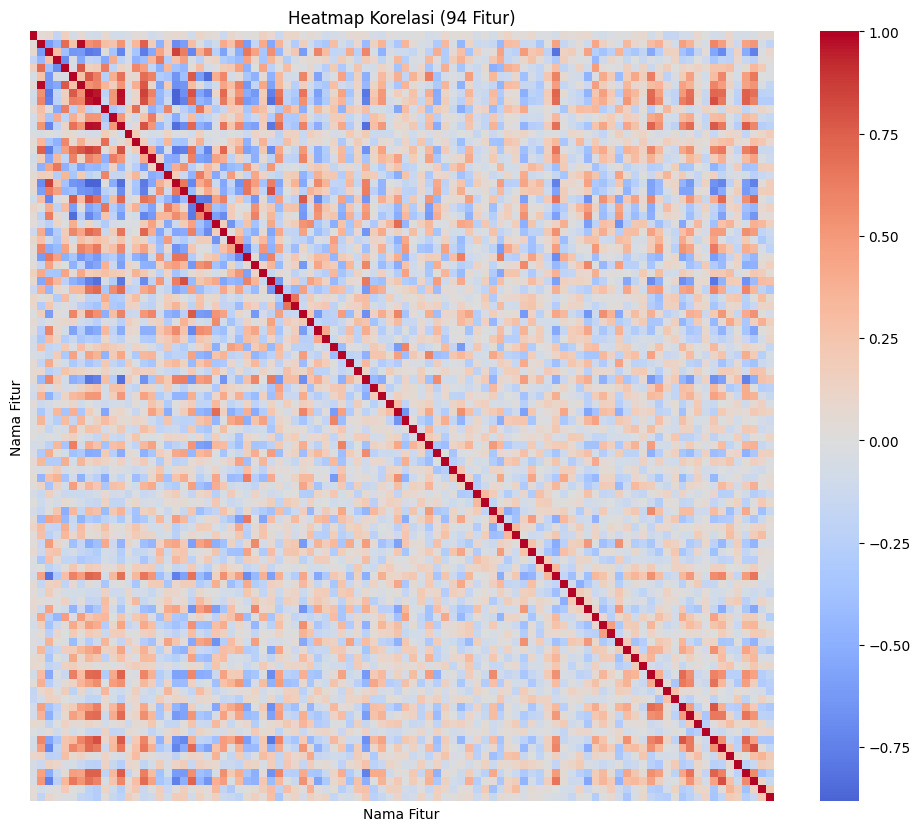

Heatmap di atas menunjukkan korelasi antar fitur.
- Warna merah/biru tua menunjukkan korelasi tinggi (redundant).
- Warna pudar (mendekati 0) menunjukkan korelasi rendah.


In [38]:
print("Load & EDA pada Fitur")
print("="*50)

# Tentukan nama file fitur
FITUR_CSV_PATH = "fitur_audio_PRO_5_kelas.csv"

# Muat Dataset Fitur
try:
    df = pd.read_csv(FITUR_CSV_PATH)
except FileNotFoundError:
    print(f"Error: File '{FITUR_CSV_PATH}' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan sel 'Feature Engineering' sebelumnya.")
else:
    print(f"Dataset fitur '{FITUR_CSV_PATH}' berhasil dimuat.")
    print(f"Ukuran data: {df.shape}")

    # Pisahkan Fitur (X) dan Target (y)
    # X adalah semua kolom KECUALI 'target'
    X = df.drop('target', axis=1)
    
    # y adalah HANYA kolom 'target'
    y = df['target']
    
    print(f"\nJumlah Fitur (X): {X.shape[1]}")
    print(f"Jumlah Target (y): {y.shape[0]}")
    
    
    # DAFTAR FITUR
    print("\n" + "="*30)
    print(f"--- DAFTAR LENGKAP {len(X.columns)} FITUR ---")
    
    feature_names = list(X.columns)
    
    # Kelompokkan fitur agar mudah dibaca
    time_series_features = [f for f in feature_names if f in 
                            ['mean', 'std', 'skewness', 'kurtosis', 'iqr', 'zcr', 'rms']]
    spectral_features = [f for f in feature_names if 'spec_' in f or 'tonnetz_' in f]
    mfcc_features = [f for f in feature_names if 'mfcc_' in f]

    print(f"\n1. Fitur Time-Series ({len(time_series_features)} Fitur):")
    print("   " + ", ".join(time_series_features))
    
    print(f"\n2. Fitur Spektral ({len(spectral_features)} Fitur):")
    print("   " + ", ".join(spectral_features))

    print(f"\n3. Fitur MFCC ({len(mfcc_features)} Fitur):")
    # Cetak 8 fitur MFCC per baris agar rapi
    for i in range(0, len(mfcc_features), 8):
        print("   " + ", ".join(mfcc_features[i:i+8]))
    
    # Encoding Label (Target)
    print("\n" + "="*30)
    print("--- Encoding Label Target (y) ---")
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("Pemetaan Label (Angka -> Teks):")
    for i, label_name in enumerate(le.classes_):
        print(f"  {i} -> {label_name}")
        
    # Simpan Label Encoder (penting untuk deployment nanti)
    joblib.dump(le, 'label_encoder.pkl')
    print("\nFile 'label_encoder.pkl' berhasil disimpan.")


    # Melihat Statistik Fitur (EDA)
    print("\n" + "="*30)
    print("--- Statistik Deskriptif Fitur (X) ---")
    # Tampilkan 5 baris pertama dan transpose agar mudah dibaca
    print(X.describe().T.head())


    # Melihat Korelasi Fitur (EDA)
    print("\n" + "="*30)
    print("--- Analisis Korelasi Fitur ---")
    
    # Menghitung korelasi
    corr_matrix = X.corr()
    
    # Visualisasi dengan Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
                xticklabels=False, yticklabels=False) # Label false agar tidak berantakan
    plt.title("Heatmap Korelasi (94 Fitur)")
    plt.xlabel("Nama Fitur")
    plt.ylabel("Nama Fitur")
    plt.show()

    print("Heatmap di atas menunjukkan korelasi antar fitur.")
    print("- Warna merah/biru tua menunjukkan korelasi tinggi (redundant).")
    print("- Warna pudar (mendekati 0) menunjukkan korelasi rendah.")

### Verifikasi Missing Value  

Kita melakukan pemeriksaan akhir untuk memastikan data fitur (`X`) tidak memiliki nilai yang hilang (`NaN`). Langkah ini wajib dilakukan karena algoritma *machine learning* (seperti deteksi outlier) akan gagal jika menemukan `NaN`.

In [39]:
print("Verifikasi Missing Value")
print("="*50)

# Pastikan X sudah ada dari Sel 7
if 'X' not in locals():
    print("Error: Variabel 'X' tidak ditemukan.")
    print("Harap jalankan 'Sel 7 (Load & EDA)' terlebih dahulu.")
else:
    print(f"Memeriksa missing values pada data X (Bentuk: {X.shape})...")
    
    # Hitung jumlah missing values per kolom
    missing_values = X.isnull().sum()
    
    # Hitung total missing values di seluruh DataFrame
    total_missing = missing_values.sum()
    
    if total_missing == 0:
        print("\nSUKSES: Tidak ditemukan missing value.")
        print("Data (X) bersih dan siap untuk langkah Outlier Detection.")
    else:
        print(f"\nPERINGATAN: Ditemukan total {total_missing} missing value.")
        print("Berikut adalah kolom yang memiliki missing value:")
        # Tampilkan hanya kolom yang punya missing value
        print(missing_values[missing_values > 0])
        
        print("\nREKOMENDASI: Anda harus menangani ini sebelum lanjut.")
        print("Misalnya dengan 'X = X.dropna()' atau menggunakan 'SimpleImputer'.")

Verifikasi Missing Value
Memeriksa missing values pada data X (Bentuk: (200, 94))...

SUKSES: Tidak ditemukan missing value.
Data (X) bersih dan siap untuk langkah Outlier Detection.


### Deteksi & Penanganan Outlier  

Kita menggunakan `IsolationForest` untuk menemukan dan menghapus data anomali (outlier) yang dapat mengganggu model.  

Langkah ini:  
1.  **Melatih** `IsolationForest` untuk menandai baris sebagai normal (1) atau outlier (-1).
2.  **Membersihkan** data dengan menghapus outlier, menghasilkan `X_cleaned` dan `y_cleaned`.
3.  **Memvisualisasikan** hasilnya menggunakan PCA (melihat sebaran outlier) dan histogram (melihat data sebelum vs sesudah dibersihkan).

Outlier Detection, Handling, & Visualisasi
Ukuran data asli (X): (200, 94)
Ukuran data asli (y): (200,)

Mendeteksi outlier menggunakan IsolationForest...

Deteksi selesai.
   Jumlah data normal (inliers): 196
   Jumlah data pencilan (outliers) terdeteksi: 4

Data outlier telah dihapus.
Ukuran data (X) setelah dibersihkan: (196, 94)
Ukuran data (y) setelah dibersihkan: (196,)

Variabel baru telah dibuat: 'X_cleaned' dan 'y_cleaned'

Visualisasi Hasil Outlier Detection

Membuat plot PCA untuk sebaran outlier


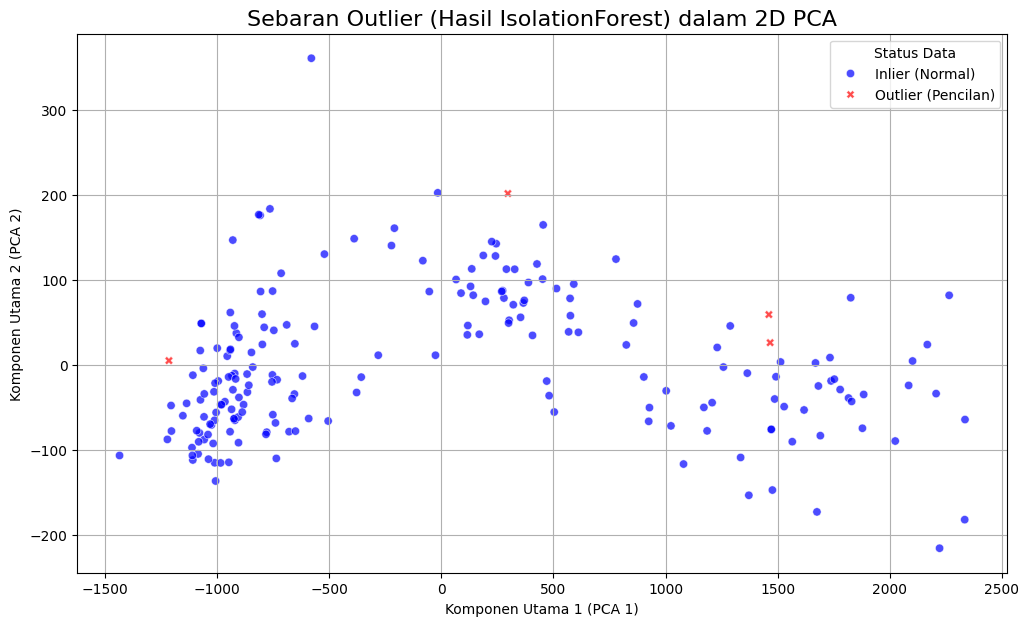


Membuat plot perbandingan distribusi fitur...


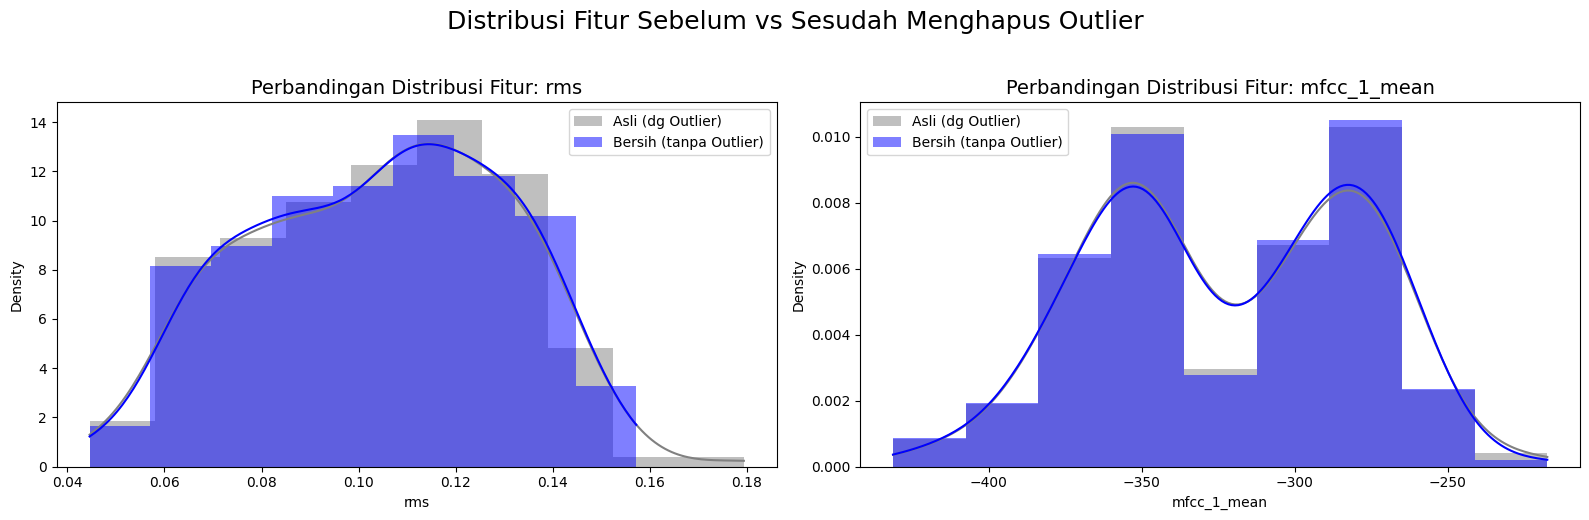


Visualisasi outlier selesai.
Kita akan menggunakan 'X_cleaned' dan 'y_cleaned' untuk langkah selanjutnya.


In [40]:
print("Outlier Detection, Handling, & Visualisasi")
print("="*50)

# Pastikan X dan y_encoded sudah ada dari Sel 7
if 'X' not in locals() or 'y_encoded' not in locals():
    print("Error: Variabel 'X' atau 'y_encoded' tidak ditemukan.")
    print("Pastikan Sel 7 (Load & EDA) sudah dijalankan terlebih dahulu.")
else:
    print(f"Ukuran data asli (X): {X.shape}")
    print(f"Ukuran data asli (y): {y_encoded.shape}")

    # DETEKSI & HANDLING
    # Inisialisasi IsolationForest
    iso_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)

    print("\nMendeteksi outlier menggunakan IsolationForest...")
    outlier_preds = iso_forest.fit_predict(X) # Hasil: 1 (inlier), -1 (outlier)

    # Hitung jumlah outlier
    jumlah_outlier = (outlier_preds == -1).sum()
    jumlah_inlier = (outlier_preds == 1).sum()

    print(f"\nDeteksi selesai.")
    print(f"   Jumlah data normal (inliers): {jumlah_inlier}")
    print(f"   Jumlah data pencilan (outliers) terdeteksi: {jumlah_outlier}")

    # Buat mask untuk memfilter data
    mask_inliers = (outlier_preds == 1)

    # Terapkan mask ke X dan y
    X_cleaned = X[mask_inliers]
    y_cleaned = y_encoded[mask_inliers].astype(int) # Pastikan y juga difilter

    print("\nData outlier telah dihapus.")
    print(f"Ukuran data (X) setelah dibersihkan: {X_cleaned.shape}")
    print(f"Ukuran data (y) setelah dibersihkan: {y_cleaned.shape}")
    print("\nVariabel baru telah dibuat: 'X_cleaned' dan 'y_cleaned'")

    # VISUALISASI HASIL
    print("\n" + "="*30)
    print("Visualisasi Hasil Outlier Detection")
    
    # Sebaran Outlier (PCA 2D)
    print("\nMembuat plot PCA untuk sebaran outlier")
    
    pca = PCA(n_components=2, random_state=42)
    # Gunakan data X ASLI (sebelum dihapus) untuk melihat perbedaannya
    X_pca = pca.fit_transform(X) 

    df_plot = pd.DataFrame(data=X_pca, columns=['PCA 1', 'PCA 2'])
    # Buat label status berdasarkan hasil prediksi 'outlier_preds'
    df_plot['status'] = np.where(outlier_preds == 1, 'Inlier (Normal)', 'Outlier (Pencilan)')
    
    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        x='PCA 1', y='PCA 2',
        hue='status',
        style='status',
        data=df_plot,
        alpha=0.7,
        palette={'Inlier (Normal)': 'blue', 'Outlier (Pencilan)': 'red'}
    )
    plt.title('Sebaran Outlier (Hasil IsolationForest) dalam 2D PCA', fontsize=16)
    plt.xlabel('Komponen Utama 1 (PCA 1)')
    plt.ylabel('Komponen Utama 2 (PCA 2)')
    plt.legend(title='Status Data')
    plt.grid(True)
    plt.show()

    # Perbandingan Distribusi Fitur
    print("\nMembuat plot perbandingan distribusi fitur...")
    
    # Pilih 2 fitur sebagai sampel (misal 'rms' dan 'mfcc_1_mean')
    fitur_untuk_dicek = ['rms', 'mfcc_1_mean'] 
    
    plt.figure(figsize=(16, 5))
    
    for i, nama_fitur in enumerate(fitur_untuk_dicek):
        # Pastikan fitur ada di data, jika tidak, lewati
        if nama_fitur not in X.columns:
            print(f"Info: Fitur '{nama_fitur}' tidak ditemukan, skipping plot.")
            continue
            
        plt.subplot(1, 2, i + 1)
        
        # Plot distribusi data ASLI (dengan outlier)
        sns.histplot(data=X, x=nama_fitur, color="gray", label='Asli (dg Outlier)', kde=True, stat="density", linewidth=0)
        
        # Plot distribusi data BERSIH (tanpa outlier)
        sns.histplot(data=X_cleaned, x=nama_fitur, color="blue", label='Bersih (tanpa Outlier)', kde=True, stat="density", linewidth=0)

        plt.title(f'Perbandingan Distribusi Fitur: {nama_fitur}', fontsize=14)
        plt.legend()

    plt.suptitle('Distribusi Fitur Sebelum vs Sesudah Menghapus Outlier', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()
    
    print("\nVisualisasi outlier selesai.")
    print("Kita akan menggunakan 'X_cleaned' dan 'y_cleaned' untuk langkah selanjutnya.")

### Split Data & Normalisasi  

Kita sekarang mempersiapkan data bersih (`X_cleaned`, `y_cleaned`) untuk dilatih.  

1.  **Split Data**: Membagi data menjadi 80% latih (train) dan 20% uji (test). `stratify=y_cleaned` digunakan agar proporsi 5 kelas kita tetap seimbang di kedua set.
2.  **Normalisasi**: Menggunakan `StandardScaler` untuk mengubah skala fitur (rata-rata 0, std-dev 1). Scaler ini di-`fit` **hanya** pada data latih dan disimpan sebagai `scaler.pkl` untuk prediksi nanti.
3.  **Visualisasi**: Memastikan `stratify` berhasil (plot 1) dan melihat efek normalisasi pada data (plot 2).

Split Data, Normalisasi, & Visualisasi
Data berhasil dibagi (split):
   X_train (latih): (156, 94)
   X_test (uji):    (40, 94)
   y_train (latih): (156,)
   y_test (uji):    (40,)

Membuat visualisasi proporsi kelas (Train vs Test)...


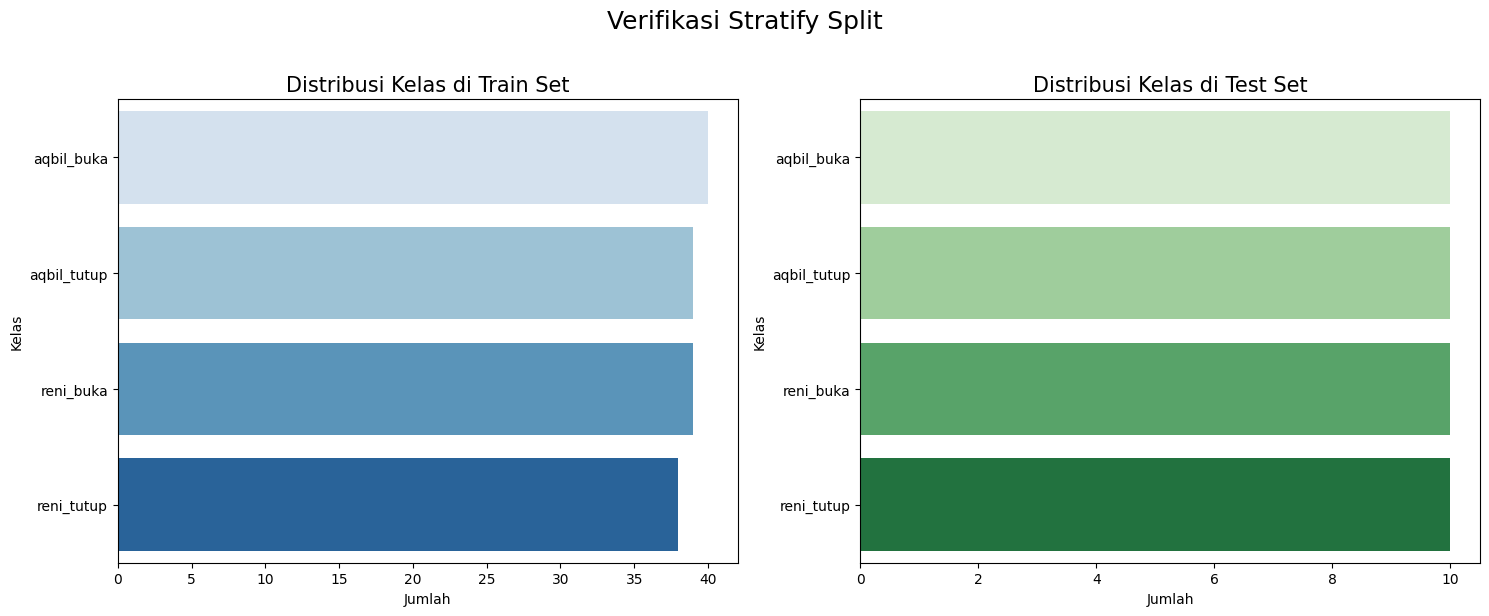

Proporsi kelas di Train dan Test set terlihat seimbang (stratify berhasil).

Melakukan normalisasi (StandardScaler)...
Normalisasi selesai.

Membuat visualisasi efek normalisasi (Sebelum vs Sesudah)...


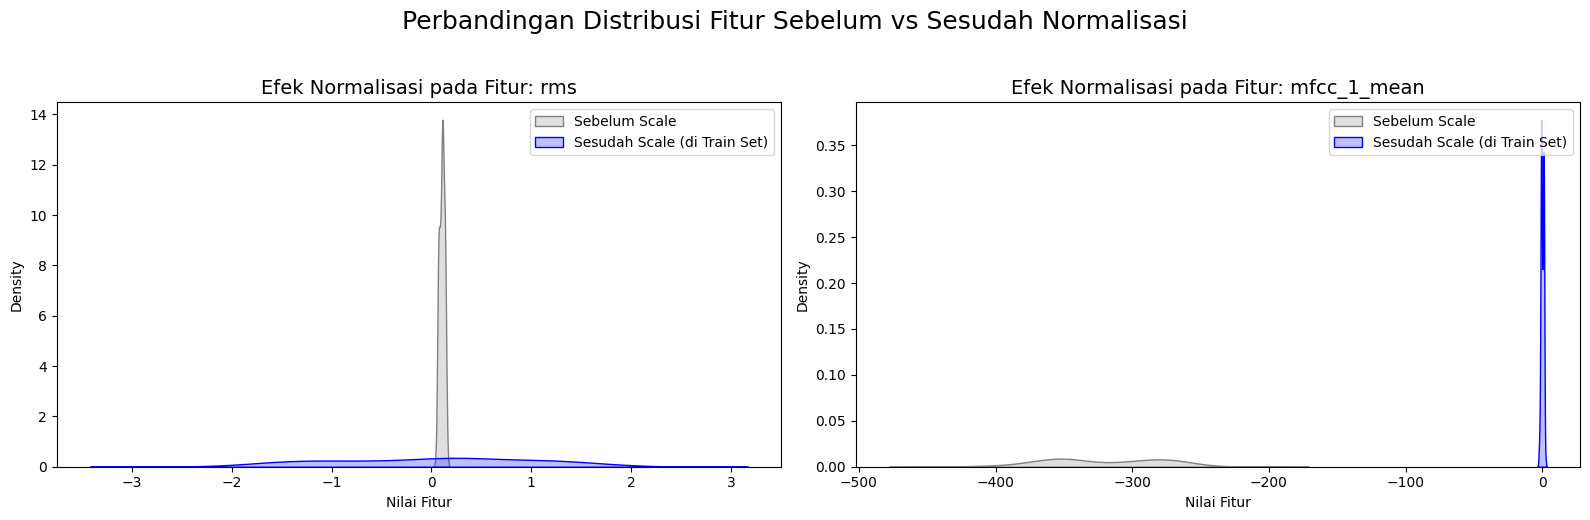

Distribusi 'Sesudah' terlihat berpusat di 0 (normalisasi berhasil).

Contoh 5 baris pertama X_train setelah normalisasi:
       mean       std  skewness  kurtosis       iqr       zcr       rms  \
0 -0.106557 -1.578922  0.820460  1.043801 -1.429835 -0.890626 -1.528264   
1  0.013296  0.538974  0.562383 -0.365686  0.293257 -1.186905  0.375284   
2  0.017196 -0.100112  0.272041 -0.653158  1.378236 -1.315620 -0.020777   
3 -0.589331 -0.819641  1.385028  0.161465 -0.820820 -0.547110 -0.857085   
4  3.069667  0.002958  0.381209 -0.664948  1.466561 -1.099740  0.185662   

   spec_centroid  spec_bandwidth  spec_contrast  ...  mfcc_18_skew  \
0      -0.913476       -0.973372      -1.621915  ...     -0.872337   
1      -0.927175       -0.676176      -0.241817  ...     -1.354931   
2      -1.084240       -0.633693       2.583044  ...      0.588058   
3      -0.650448       -0.386619       0.259837  ...     -0.325689   
4      -1.110211       -0.935106       1.920885  ...      0.594584   

   mfcc

In [41]:
print("Split Data, Normalisasi, & Visualisasi")
print("="*50)

# Pastikan X_cleaned dan y_cleaned sudah ada dari Sel 8
if 'X_cleaned' not in locals() or 'y_cleaned' not in locals():
    print("Error: Variabel 'X_cleaned' atau 'y_cleaned' tidak ditemukan.")
    print("Harap jalankan 'Sel 8' terlebih dahulu.")
else:
    # Train-Test Split
    X_train_orig, X_test_orig, y_train, y_test = train_test_split(
        X_cleaned, 
        y_cleaned, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_cleaned 
    )

    print("Data berhasil dibagi (split):")
    print(f"   X_train (latih): {X_train_orig.shape}")
    print(f"   X_test (uji):    {X_test_orig.shape}")
    print(f"   y_train (latih): {y_train.shape}")
    print(f"   y_test (uji):    {y_test.shape}")
    
    # Salin untuk digunakan di visualisasi normalisasi nanti
    X_train_unscaled = X_train_orig.copy()

    # VISUALISASI HASIL SPLIT
    print("\nMembuat visualisasi proporsi kelas (Train vs Test)...")
    try:
        le = joblib.load('label_encoder.pkl')
        y_train_labels = le.inverse_transform(y_train)
        y_test_labels = le.inverse_transform(y_test)
        
        plt.figure(figsize=(15, 6))
        
        # Plot Train Set
        plt.subplot(1, 2, 1)
        sns.countplot(y=y_train_labels, order=le.classes_, palette='Blues')
        plt.title('Distribusi Kelas di Train Set', fontsize=15)
        plt.xlabel('Jumlah')
        plt.ylabel('Kelas')
        
        # Plot Test Set
        plt.subplot(1, 2, 2)
        sns.countplot(y=y_test_labels, order=le.classes_, palette='Greens')
        plt.title('Distribusi Kelas di Test Set', fontsize=15)
        plt.xlabel('Jumlah')
        plt.ylabel('Kelas')
        
        plt.suptitle('Verifikasi Stratify Split', fontsize=18, y=1.02)
        plt.tight_layout()
        plt.show()
        print("Proporsi kelas di Train dan Test set terlihat seimbang (stratify berhasil).")
        
    except FileNotFoundError:
        print("Warning: 'label_encoder.pkl' tidak ditemukan. Skipping visualisasi split.")
    
    # Normalisasi (StandardScaler)
    print("\nMelakukan normalisasi (StandardScaler)...")
    scaler = StandardScaler()
    feature_columns = X_train_orig.columns

    # PENTING: Fit HANYA pada X_train
    X_train_scaled = scaler.fit_transform(X_train_orig)
    # PENTING: Transform pada X_test
    X_test_scaled = scaler.transform(X_test_orig)

    # Konversi kembali ke DataFrame
    X_train = pd.DataFrame(X_train_scaled, columns=feature_columns)
    X_test = pd.DataFrame(X_test_scaled, columns=feature_columns)

    print("Normalisasi selesai.")
    
    # VISUALISASI EFEK NORMALISASI
    print("\nMembuat visualisasi efek normalisasi (Sebelum vs Sesudah)...")
    
    # Pilih 2 fitur sebagai sampel
    fitur_untuk_dicek = ['rms', 'mfcc_1_mean'] 
    
    plt.figure(figsize=(16, 5))
    
    for i, nama_fitur in enumerate(fitur_untuk_dicek):
        if nama_fitur not in X_train.columns:
            print(f"Info: Fitur '{nama_fitur}' tidak ada, skipping plot.")
            continue
            
        plt.subplot(1, 2, i + 1)
        
        # Plot distribusi SEBELUM di-scale
        sns.kdeplot(data=X_train_unscaled, x=nama_fitur, label='Sebelum Scale', 
                    color='gray', fill=True)
        
        # Plot distribusi SESUDAH di-scale
        sns.kdeplot(data=X_train, x=nama_fitur, label='Sesudah Scale (di Train Set)', 
                    color='blue', fill=True)
        
        plt.title(f'Efek Normalisasi pada Fitur: {nama_fitur}', fontsize=14)
        plt.legend()
        plt.xlabel('Nilai Fitur')

    plt.suptitle('Perbandingan Distribusi Fitur Sebelum vs Sesudah Normalisasi', fontsize=18, y=1.03)
    plt.tight_layout()
    plt.show()
    print("Distribusi 'Sesudah' terlihat berpusat di 0 (normalisasi berhasil).")

    print("\nContoh 5 baris pertama X_train setelah normalisasi:")
    print(X_train.head())

    # Simpan Scaler
    scaler_path = 'scaler.pkl'
    joblib.dump(scaler, scaler_path)
    print(f"\nScaler berhasil disimpan ke: '{scaler_path}'")
    
    print("\nData siap untuk pemodelan (Ronde 1: Baseline).")
    print("Variabel yang akan dipakai: X_train, X_test, y_train, y_test")

## Pemodelan & Seleksi Fitur  

### Pemodelan (Ronde 1: Baseline)  

Kita melatih model `RandomForestClassifier` pertama kita menggunakan **semua 94 fitur** yang sudah dinormalisasi.  

Tujuannya adalah untuk mendapatkan **model baseline** sebagai patokan performa. Model ini juga akan kita gunakan untuk menganalisis fitur mana yang paling penting di langkah selanjutnya.  

Kita akan mengevaluasi performanya menggunakan:
1.  Akurasi
2.  Classification Report (Precision, Recall, F1-Score)
3.  Confusion Matrix

Pemodelan (Ronde 1: Baseline)
Melatih model RandomForestClassifier pada 94 fitur...
Model baseline (Ronde 1) berhasil dilatih.

--- Evaluasi Model Baseline ---
Akurasi Model Baseline: 100.00%

--- Classification Report ---
              precision    recall  f1-score   support

  aqbil_buka       1.00      1.00      1.00        10
 aqbil_tutup       1.00      1.00      1.00        10
   reni_buka       1.00      1.00      1.00        10
  reni_tutup       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


--- Confusion Matrix ---
Menampilkan heatmap confusion matrix...


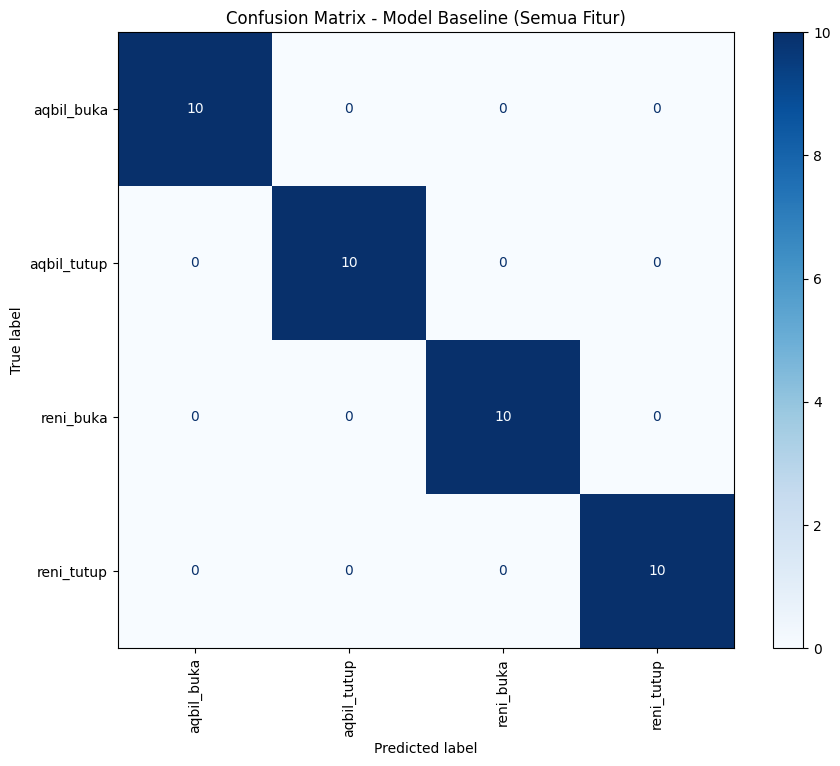


Model 'model_baseline' siap untuk dianalisis di langkah selanjutnya.


In [42]:
print("Pemodelan (Ronde 1: Baseline)")
print("="*50)

# Pastikan data latih dan uji sudah ada
if 'X_train' not in locals() or 'y_train' not in locals() or 'X_test' not in locals() or 'y_test' not in locals():
    print("Error: Variabel (X_train, y_train, X_test, y_test) tidak ditemukan.")
    print("Harap jalankan 'Sel 9 (Split & Normalisasi)' terlebih dahulu.")
else:
    print(f"Melatih model RandomForestClassifier pada {X_train.shape[1]} fitur...")
    
    # Inisialisasi Model
    # random_state=42 untuk hasil yang konsisten
    model_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Latih (Fit) Model
    model_baseline.fit(X_train, y_train)
    
    print("Model baseline (Ronde 1) berhasil dilatih.")
    
    # Prediksi pada Data Uji
    y_pred = model_baseline.predict(X_test)
    
    # Evaluasi Model
    print("\n" + "="*30)
    print("--- Evaluasi Model Baseline ---")
    
    # Hitung Akurasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi Model Baseline: {accuracy * 100:.2f}%")
    
    # Tampilkan Classification Report (Precision, Recall, F1-Score)
    try:
        # Muat label encoder yang disimpan di Sel 7
        le = joblib.load('label_encoder.pkl')
        target_names = le.classes_
        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred, target_names=target_names))
    except FileNotFoundError:
        print("\nWarning: File 'label_encoder.pkl' tidak ditemukan.")
        print("Menampilkan report dengan label angka:")
        print(classification_report(y_test, y_pred))
        target_names = np.unique(y_encoded) # Gunakan label angka
    
    # Visualisasi Confusion Matrix
    print("\n--- Confusion Matrix ---")
    print("Menampilkan heatmap confusion matrix...")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        ax=ax, 
        cmap='Blues', 
        display_labels=target_names,
        xticks_rotation='vertical'
    )
    plt.title('Confusion Matrix - Model Baseline (Semua Fitur)')
    plt.show()
    
    print("\nModel 'model_baseline' siap untuk dianalisis di langkah selanjutnya.")

### Analisis & Seleksi Feature Importance  

Kita menggunakan `model_baseline` (Ronde 1) untuk mencari tahu fitur mana yang paling penting.  

1.  **Ekstraksi**: Mengambil `.feature_importances_` dari model.
2.  **Seleksi**: Menetapkan target 30% (`TARGET_IMPORTANCE = 0.30`) dan memilih fitur-fitur teratas yang secara kumulatif berkontribusi pada 30% *importance* tersebut.
3.  **Visualisasi**: Membuat plot batang dari **semua 94 fitur**, diwarnai [HIJAU] (lolos 30%) atau [MERAH] (gagal). Garis biru menunjukkan nilai *importance* terendah yang lolos.
4.  **Hasil**: Mencetak daftar akhir fitur yang terpilih (`list_fitur_terbaik`).

Feature Importance Analysis & Selection (75%)
Total 94 fitur dianalisis.

Seleksi Fitur (Target: 75% Importance Kumulatif)
Target importance: 75.0%
Jumlah fitur asli: 94
Jumlah fitur terpilih: 24
Total importance dari fitur terpilih: 76.36%
Nilai 'Importance' minimum yang lolos: 0.015958

--- Visualisasi Feature Importance (Semua 94 Fitur) ---


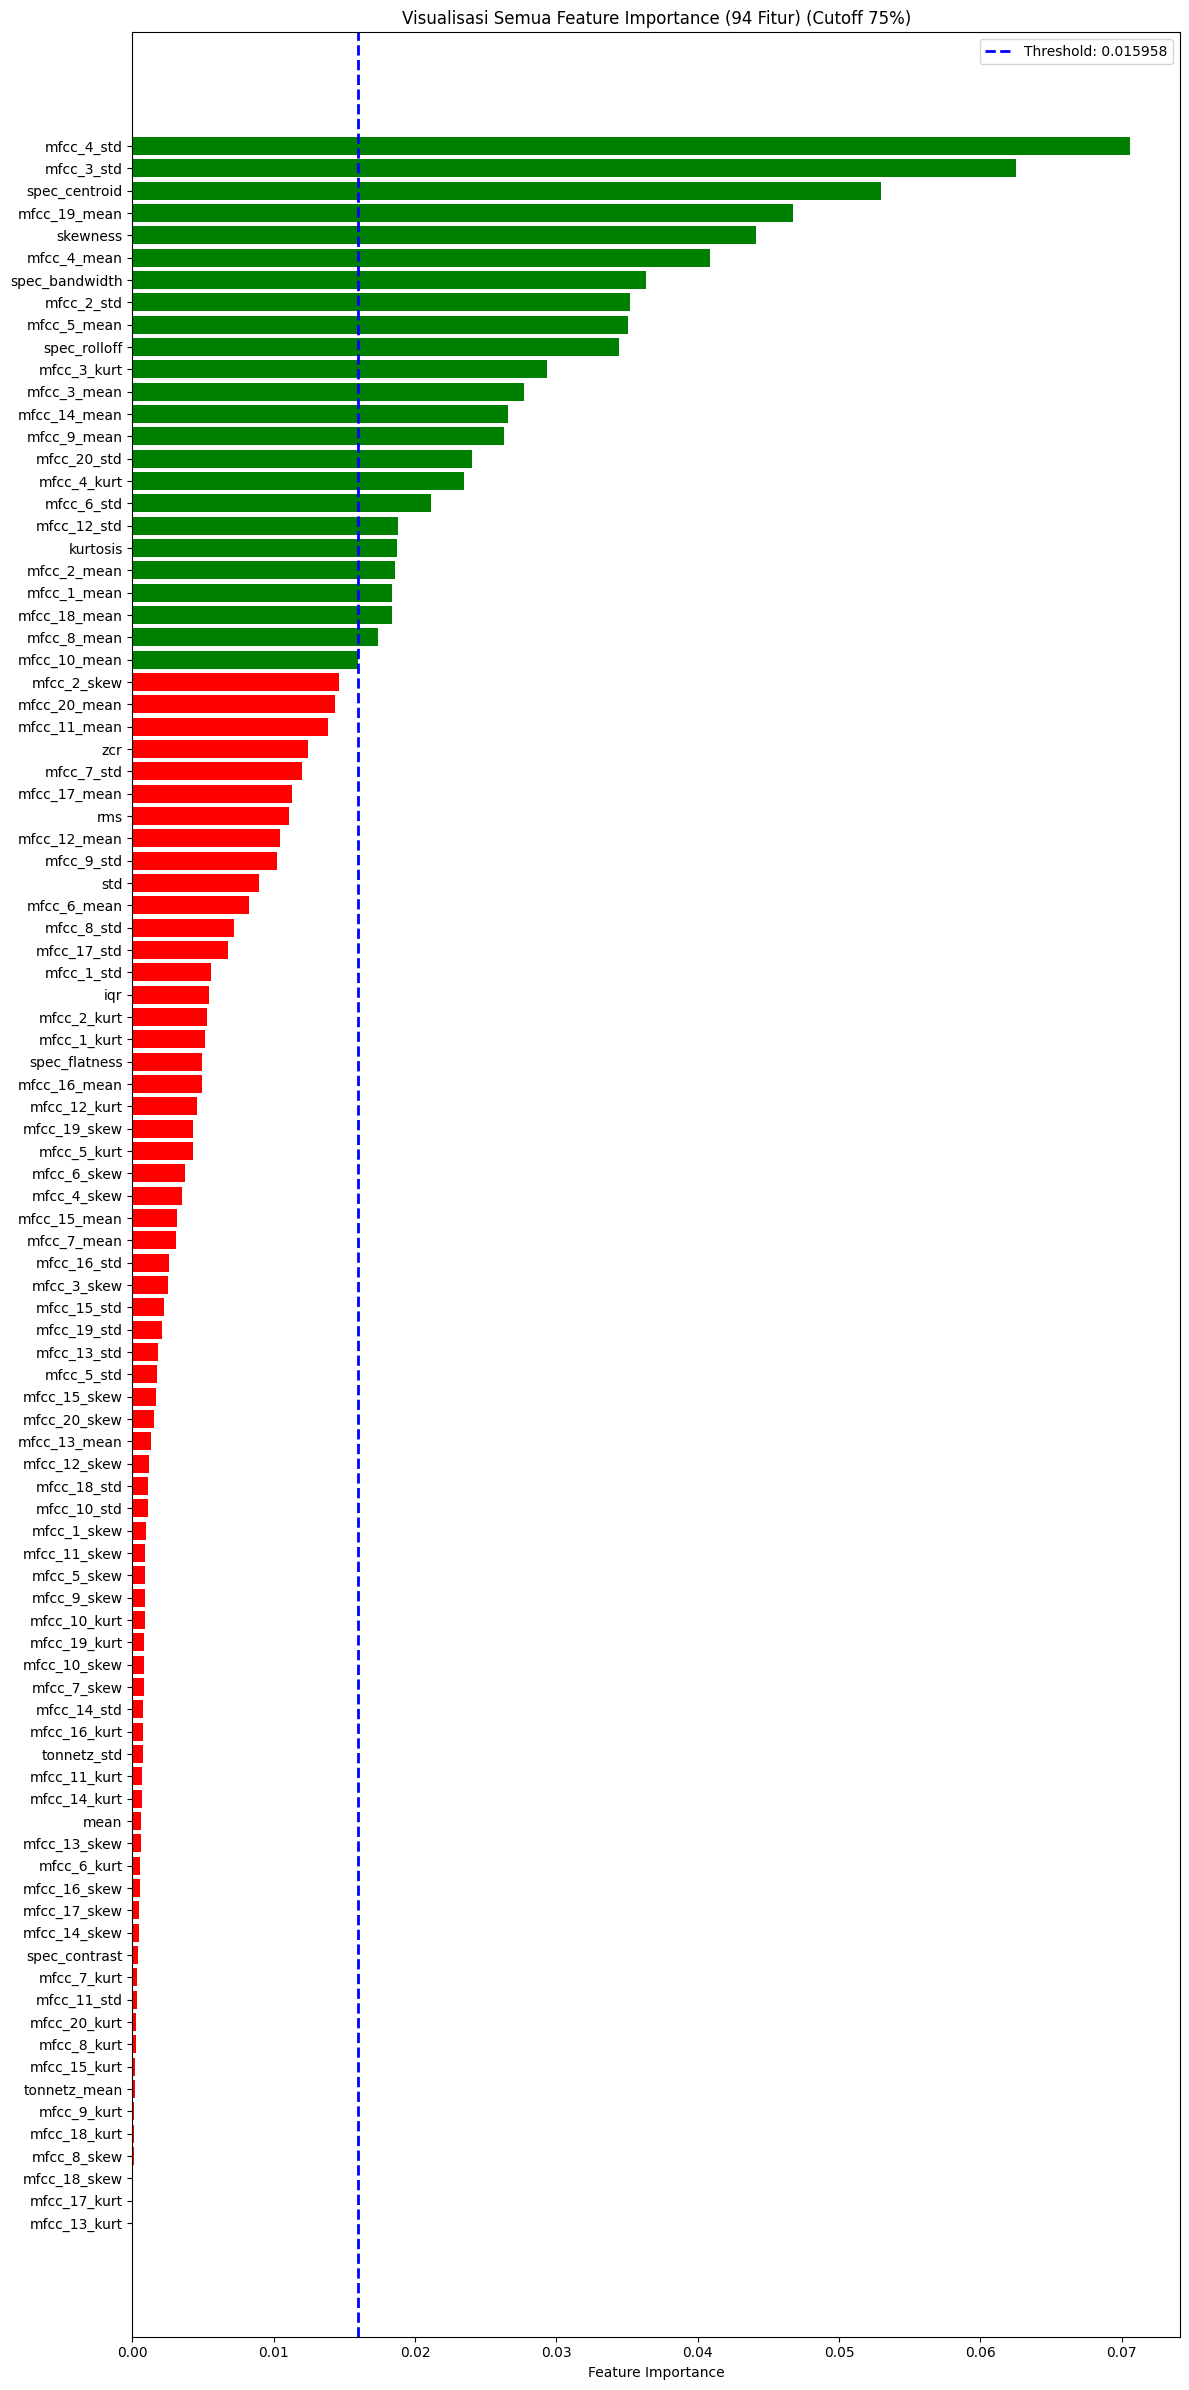

Keterangan:
  [HIJAU] = Fitur terpilih (Importance >= Threshold)
  [MERAH] = Fitur tidak terpilih (Importance < Threshold)

--- Daftar LENGKAP 24 Fitur yang Dipilih ---
   1. mfcc_4_std
   2. mfcc_3_std
   3. spec_centroid
   4. mfcc_19_mean
   5. skewness
   6. mfcc_4_mean
   7. spec_bandwidth
   8. mfcc_2_std
   9. mfcc_5_mean
  10. spec_rolloff
  11. mfcc_3_kurt
  12. mfcc_3_mean
  13. mfcc_14_mean
  14. mfcc_9_mean
  15. mfcc_20_std
  16. mfcc_4_kurt
  17. mfcc_6_std
  18. mfcc_12_std
  19. kurtosis
  20. mfcc_2_mean
  21. mfcc_1_mean
  22. mfcc_18_mean
  23. mfcc_8_mean
  24. mfcc_10_mean


In [43]:
print("Feature Importance Analysis & Selection (75%)")
print("="*50)

# Pastikan model baseline dan X_train sudah ada
if 'model_baseline' not in locals() or 'X_train' not in locals():
    print("Error: Variabel 'model_baseline' atau 'X_train' tidak ditemukan.")
    print("Harap jalankan 'Sel 10' terlebih dahulu.")
else:
    # Dapatkan Feature Importance dari Model Baseline
    importances = model_baseline.feature_importances_
    feature_names = X_train.columns
    
    # Buat DataFrame untuk analisis
    df_importance = pd.DataFrame({
        'fitur': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    print(f"Total {len(df_importance)} fitur dianalisis.")

    # SELEKSI FITUR & KALKULASI THRESHOLD
    print("\n" + "="*30)
    print("Seleksi Fitur (Target: 75% Importance Kumulatif)")

    df_importance['cumulative_importance'] = df_importance['importance'].cumsum()
    TARGET_IMPORTANCE = 0.75
    
    # Cari fitur yang lolos 75%
    df_terbaik = df_importance[df_importance['cumulative_importance'] <= TARGET_IMPORTANCE]
    if len(df_terbaik) < len(df_importance):
        df_terbaik = pd.concat([df_terbaik, df_importance.iloc[[len(df_terbaik)]]])

    list_fitur_terbaik = df_terbaik['fitur'].tolist()
    total_importance_tercapai = df_terbaik['importance'].sum()
    jumlah_fitur_terpilih = len(list_fitur_terbaik)

    # Ambil nilai importance terendah dari fitur yang terpilih
    absolute_threshold = df_terbaik['importance'].min()

    print(f"Target importance: {TARGET_IMPORTANCE * 100}%")
    print(f"Jumlah fitur asli: {len(feature_names)}")
    print(f"Jumlah fitur terpilih: {jumlah_fitur_terpilih}")
    print(f"Total importance dari fitur terpilih: {total_importance_tercapai * 100:.2f}%")
    print(f"Nilai 'Importance' minimum yang lolos: {absolute_threshold:.6f}")

    # VISUALISASI FEATURE IMPORTANCE (Semua 94 Fitur)
    print("\n" + "="*30)
    print("--- Visualisasi Feature Importance (Semua 94 Fitur) ---")

    # Ukuran plot dibuat sangat tinggi
    plt.figure(figsize=(12, 24)) # Dibuat lebih tinggi (misal 24)
    
    # Ambil SEMUA fitur
    top_features_df = df_importance.copy()
    
    # Buat daftar warna berdasarkan threshold
    colors = ['green' if imp >= absolute_threshold else 'red' for imp in top_features_df['importance']]
    
    # Buat plot bar horizontal
    plt.barh(range(len(top_features_df)), top_features_df['importance'], color=colors)
    plt.yticks(range(len(top_features_df)), top_features_df['fitur'])
    
    plt.xlabel('Feature Importance')
    # Judul diubah
    plt.title(f'Visualisasi Semua Feature Importance (94 Fitur) (Cutoff 75%)')
    
    # Gambar garis threshold
    plt.axvline(x=absolute_threshold, color='blue', linestyle='--', linewidth=2, 
                label=f'Threshold: {absolute_threshold:.6f}')
    
    plt.legend()
    plt.gca().invert_yaxis() # Fitur terpenting di atas
    plt.tight_layout()
    plt.show()
    
    print("Keterangan:")
    print("  [HIJAU] = Fitur terpilih (Importance >= Threshold)")
    print("  [MERAH] = Fitur tidak terpilih (Importance < Threshold)")

    # DAFTAR LENGKAP FITUR TERPILIH (Tetap dipertahankan)
    print("\n" + "="*30)
    print(f"--- Daftar LENGKAP {len(list_fitur_terbaik)} Fitur yang Dipilih ---")
    
    for i, fitur in enumerate(list_fitur_terbaik):
        print(f"  {i+1:2d}. {fitur}")

### Pemodelan (Ronde 2: Model Final)  

Sekarang kita melatih `RandomForestClassifier` kedua. Kali ini, kita **hanya** menggunakan fitur-fitur terbaik yang telah kita pilih (`list_fitur_terbaik`).  

Tujuannya adalah untuk membuat model final yang lebih ringan dan efisien. Kita akan mengevaluasi performanya dan membandingkannya langsung dengan akurasi model baseline (yang menggunakan 94 fitur).

Pemodelan (Ronde 2: Model Final)
Menggunakan 24 fitur terbaik yang telah dipilih.

Bentuk data latih baru (X_train_final): (156, 24)
Bentuk data uji baru (X_test_final): (40, 24)
Model final (Ronde 2) berhasil dilatih.

--- Evaluasi Model Final ---
Akurasi Model Final: 100.00%
Akurasi Model Baseline (sebelumnya): 100.00%
Perbedaan: +0.00%

--- Classification Report (Final) ---
              precision    recall  f1-score   support

  aqbil_buka       1.00      1.00      1.00        10
 aqbil_tutup       1.00      1.00      1.00        10
   reni_buka       1.00      1.00      1.00        10
  reni_tutup       1.00      1.00      1.00        10

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40


--- Confusion Matrix (Final) ---


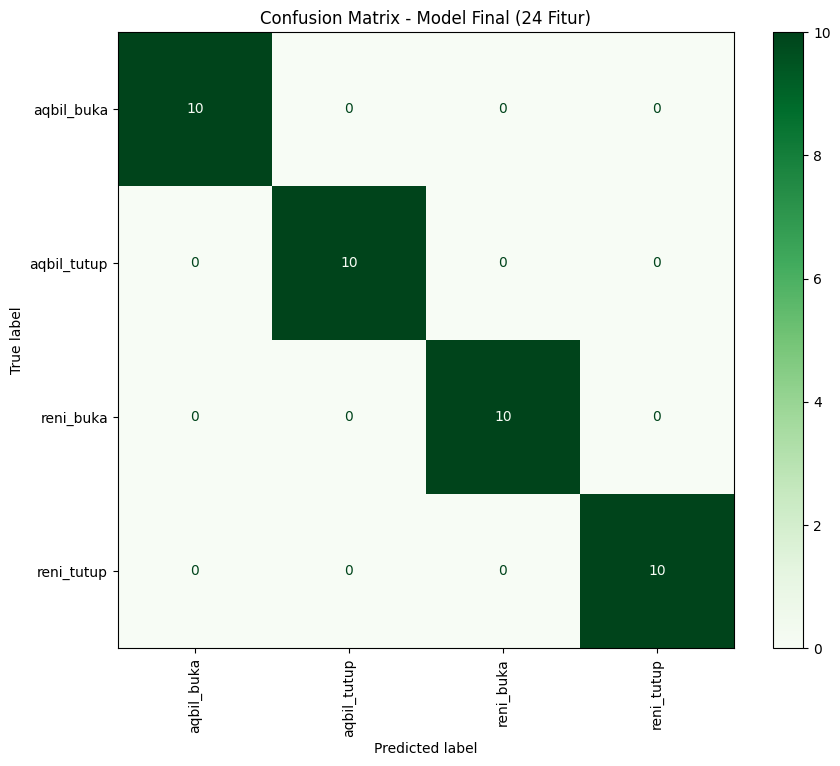


Model 'model_final' adalah model akhir kita.


In [44]:
print("Pemodelan (Ronde 2: Model Final)")
print("="*50)

# Pastikan semua variabel yang dibutuhkan ada
if 'X_train' not in locals() or 'X_test' not in locals() or 'list_fitur_terbaik' not in locals():
    print("Error: Variabel (X_train, X_test, list_fitur_terbaik) tidak ditemukan.")
    print("Harap jalankan Sel 9, 10, dan 11 terlebih dahulu.")
else:
    print(f"Menggunakan {len(list_fitur_terbaik)} fitur terbaik yang telah dipilih.")

    # Filter DataFrame untuk HANYA menggunakan fitur terbaik
    X_train_final = X_train[list_fitur_terbaik]
    X_test_final = X_test[list_fitur_terbaik]

    print(f"\nBentuk data latih baru (X_train_final): {X_train_final.shape}")
    print(f"Bentuk data uji baru (X_test_final): {X_test_final.shape}")

    # Inisialisasi Model Final
    # Kita gunakan parameter yang sama dengan baseline
    model_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    # Latih (Fit) Model Final
    # Kita latih pada data latih yang sudah difilter
    model_final.fit(X_train_final, y_train)
    
    print("Model final (Ronde 2) berhasil dilatih.")
    
    # Prediksi pada Data Uji (yang juga sudah difilter)
    y_pred_final = model_final.predict(X_test_final)
    
    # Evaluasi Model Final
    print("\n" + "="*30)
    print("--- Evaluasi Model Final ---")
    
    # Hitung Akurasi
    accuracy_final = accuracy_score(y_test, y_pred_final)
    print(f"Akurasi Model Final: {accuracy_final * 100:.2f}%")
    
    # Bandingkan dengan baseline
    try:
        # 'accuracy' dari Sel 10
        print(f"Akurasi Model Baseline (sebelumnya): {accuracy * 100:.2f}%")
        perbedaan = accuracy_final - accuracy
        print(f"Perbedaan: {perbedaan * 100:+.2f}%")
    except NameError:
        print("Variabel 'accuracy' dari baseline tidak ditemukan untuk perbandingan.")

    # Tampilkan Classification Report
    try:
        le = joblib.load('label_encoder.pkl')
        target_names = le.classes_
        print("\n--- Classification Report (Final) ---")
        print(classification_report(y_test, y_pred_final, target_names=target_names))
    except FileNotFoundError:
        print("\nWarning: File 'label_encoder.pkl' tidak ditemukan.")
        print(classification_report(y_test, y_pred_final))
        target_names = np.unique(y_encoded)
    
    # Visualisasi Confusion Matrix (Final)
    print("\n--- Confusion Matrix (Final) ---")
    
    fig, ax = plt.subplots(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred_final, 
        ax=ax, 
        cmap='Greens',
        display_labels=target_names,
        xticks_rotation='vertical'
    )
    plt.title(f'Confusion Matrix - Model Final ({len(list_fitur_terbaik)} Fitur)')
    plt.show()

    print("\nModel 'model_final' adalah model akhir kita.")

## Simpan Aset & Prediksi  

### Simpan Aset Model Final  

Ini adalah langkah terakhir dari *pipeline* pelatihan. Kita menyimpan aset-aset penting yang diperlukan untuk *deployment* (menjalankan `app.py`):  

1.  **`model_final.pkl`**: Model `RandomForestClassifier` yang sudah dilatih (dari Ronde 2).
2.  **`list_fitur_terbaik.json`**: Daftar nama-nama fitur yang dibutuhkan oleh model.

Sel ini juga memverifikasi keberadaan `scaler.pkl` (dari Sel 13) dan `label_encoder.pkl` (dari Sel 10). Keempat file ini adalah semua yang kita butuhkan untuk aplikasi prediksi.

In [45]:
print("Simpan Model Final & Aset")
print("="*50)

# Tentukan nama file untuk disimpan
MODEL_PATH = 'model_final.pkl'
FITUR_LIST_PATH = 'list_fitur_terbaik.json'
SCALER_PATH = 'scaler.pkl' 
ENCODER_PATH = 'label_encoder.pkl'

# Pastikan variabel yang dibutuhkan ada
if 'model_final' not in locals() or 'list_fitur_terbaik' not in locals():
    print("Error: Variabel 'model_final' atau 'list_fitur_terbaik' tidak ditemukan.")
    print("Harap jalankan Sel 11 dan 12 terlebih dahulu.")
else:
    # Simpan Model Final
    joblib.dump(model_final, MODEL_PATH)
    print(f"✅ Model final berhasil disimpan ke: '{MODEL_PATH}'")

    # Simpan Daftar Fitur Terbaik (menggunakan JSON)
    with open(FITUR_LIST_PATH, 'w') as f:
        json.dump(list_fitur_terbaik, f)
    print(f"✅ Daftar fitur terbaik berhasil disimpan ke: '{FITUR_LIST_PATH}'")

    # Verifikasi file lainnya (sudah disimpan sebelumnya)
    if os.path.exists(SCALER_PATH):
        print(f"✅ File scaler sudah ada: '{SCALER_PATH}'")
    else:
        print(f"⚠️ Peringatan: File '{SCALER_PATH}' tidak ditemukan. Harap jalankan Sel 9.")
        
    if os.path.exists(ENCODER_PATH):
        print(f"✅ File label encoder sudah ada: '{ENCODER_PATH}'")
    else:
        print(f"⚠️ Peringatan: File '{ENCODER_PATH}' tidak ditemukan. Harap jalankan Sel 7.")

    print("\n--- Proses Selesai ---")
    print("Anda sekarang memiliki 4 file penting untuk deployment:")
    print(f"1. {MODEL_PATH}")
    print(f"2. {SCALER_PATH}")
    print(f"3. {ENCODER_PATH}")
    print(f"4. {FITUR_LIST_PATH}")

Simpan Model Final & Aset
✅ Model final berhasil disimpan ke: 'model_final.pkl'
✅ Daftar fitur terbaik berhasil disimpan ke: 'list_fitur_terbaik.json'
✅ File scaler sudah ada: 'scaler.pkl'
✅ File label encoder sudah ada: 'label_encoder.pkl'

--- Proses Selesai ---
Anda sekarang memiliki 4 file penting untuk deployment:
1. model_final.pkl
2. scaler.pkl
3. label_encoder.pkl
4. list_fitur_terbaik.json


### Tes Prediksi  

Sebagai tes akhir, kita akan mensimulasikan *pipeline* prediksi lengkap di dalam notebook ini.  

Sel ini akan:
1.  **Memuat 4 Aset**: Memuat `model_final.pkl`, `scaler.pkl`, `label_encoder.pkl`, dan `list_fitur_terbaik.json`.
2.  **Mendefinisikan Ulang Fungsi**: Mendefinisikan ulang `extract_features_pro` dan `prediksi_suara` persis seperti yang akan digunakan di aplikasi.
3.  **Menjalankan Prediksi**: Memproses satu file audio (`FILE_UNTUK_PREDIKSI`).
4.  **Menerapkan Logika Keamanan**: Memeriksa hasil prediksi (`hasil_label`) dan keyakinan (`hasil_confidence`) terhadap `THRESHOLD_KEAMANAN` (75%) untuk memberikan status "AKSES DITERIMA" atau "AKSES DITOLAK".
5.  **Menampilkan Detail**: Mencetak fitur mentah yang digunakan, rincian probabilitas, dan hasil verifikasi.

In [46]:
print("Tes Prediksi")
print("="*50)

# TENTUKAN FILE AUDIO BARU ---
FILE_UNTUK_PREDIKSI = "dataset/aqbil/buka/buka_0.wav" 

# TENTUKAN THRESHOLD KEAMANAN ---
THRESHOLD_KEAMANAN = 0.75

# MUAT SEMUA ASET
print("Memuat aset yang disimpan...")
try:
    model = joblib.load('model_final.pkl')
    scaler = joblib.load('scaler.pkl')
    le = joblib.load('label_encoder.pkl')
    with open('list_fitur_terbaik.json', 'r') as f:
        list_fitur_terbaik = json.load(f)
    print("Aset berhasil dimuat (model, scaler, encoder, list fitur).")
except FileNotFoundError as e:
    print(f"Error: Gagal memuat aset. Pastikan file '{e.filename}' ada.")
    model = None 

# DEFINISIKAN ULANG FUNGSI EKSTRAKSI FITUR
TARGET_SR = 22050 
def extract_features_pro(file_path, sr_target=TARGET_SR, n_mfcc=20):
    try:
        y, sr = librosa.load(file_path, sr=sr_target, mono=True)
        y, _ = librosa.effects.trim(y, top_db=20)
        if len(y) < 1000: return None
        features = {
            'mean': np.mean(y), 'std': np.std(y), 'skewness': scipy.stats.skew(y),
            'kurtosis': scipy.stats.kurtosis(y), 'iqr': scipy.stats.iqr(y),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y))
        }
        S = np.abs(librosa.stft(y))
        features['spec_centroid'] = np.mean(librosa.feature.spectral_centroid(S=S))
        features['spec_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(S=S))
        features['spec_contrast'] = np.mean(librosa.feature.spectral_contrast(S=S))
        features['spec_flatness'] = np.mean(librosa.feature.spectral_flatness(S=S))
        features['spec_rolloff'] = np.mean(librosa.feature.spectral_rolloff(S=S, sr=sr))
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz)
        features['tonnetz_std'] = np.std(tonnetz)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        for i in range(n_mfcc):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
            features[f'mfcc_{i+1}_skew'] = scipy.stats.skew(mfccs[i])
            features[f'mfcc_{i+1}_kurt'] = scipy.stats.kurtosis(mfccs[i])
        return features
    except Exception as e:
        print(f"Error saat ekstrak fitur dari {file_path}: {e}")
        return None

# BUAT FUNGSI PREDIKSI (Pipeline Lengkap)
def prediksi_suara(file_path, model, scaler, list_fitur_terbaik, le):
    warnings.filterwarnings('ignore') 
    
    # Ekstrak 94 fitur
    fitur_dict = extract_features_pro(file_path)
    if fitur_dict is None:
        return "Error: Gagal memproses file audio.", None, None, None
        
    df_single = pd.DataFrame([fitur_dict])
    
    try:
        original_94_features = scaler.feature_names_in_
        df_ordered = df_single[original_94_features]
        X_scaled_all = scaler.transform(df_ordered)
        df_scaled_all = pd.DataFrame(X_scaled_all, columns=original_94_features)
        df_final = df_scaled_all[list_fitur_terbaik]

    except Exception as e:
         return f"Error: Gagal memproses pipeline: {e}", None, None, None

    # Prediksi
    prediksi_angka = model.predict(df_final)       
    prediksi_proba_all = model.predict_proba(df_final)[0] # Ambil array proba [0]
    
    # Decode
    prediksi_label = le.inverse_transform(prediksi_angka)[0] # Ambil label teks [0]
    confidence = np.max(prediksi_proba_all) # Nilai 0.0 s/d 1.0
    
    # Kembalikan semua hasil
    return prediksi_label, confidence, prediksi_proba_all, fitur_dict

# JALANKAN PREDIKSI & LOGIKA VERIFIKASI
if model is not None and os.path.exists(FILE_UNTUK_PREDIKSI):
    
    print(f"Menggunakan file: {FILE_UNTUK_PREDIKSI}")
    
    # Tampilkan audio
    ipd.display(ipd.Audio(FILE_UNTUK_PREDIKSI))
    
    # Panggil fungsi prediksi
    hasil_label, hasil_confidence, hasil_proba_all, fitur_mentah = prediksi_suara(
        FILE_UNTUK_PREDIKSI, 
        model, 
        scaler, 
        list_fitur_terbaik, 
        le
    )
    
    if hasil_confidence is not None:
        
        # TAMPILKAN FITUR YANG DIPROSES
        print(f"\n🔍 FITUR YANG DIPROSES (Nilai Mentah):")
        print(f"{'='*50}")
        print(f"Model ini menggunakan {len(list_fitur_terbaik)} fitur terbaik berikut:")
        
        for feat_name in list_fitur_terbaik:
            # Ambil nilai mentah dari dict 'fitur_mentah'
            feat_value = fitur_mentah.get(feat_name, 'N/A') 
            if isinstance(feat_value, (float, int)):
                print(f"  {feat_name:<20}: {feat_value:.6f}")
            else:
                 print(f"  {feat_name:<20}: {feat_value}")

        # Tampilkan DETAIL PREDIKSI
        print(f"\nDETAIL PREDIKSI MODEL")
        print(f"{'='*30}")
        print(f"Prediksi Mentah: **{hasil_label.upper()}**")
        print(f"Confidence: {hasil_confidence*100:.1f}%")
        
        # Tampilkan rincian probabilitas
        classes = le.classes_
        for i, cls in enumerate(classes):
            print(f"P({cls}): {hasil_proba_all[i]*100:.1f}%")

        # Tampilkan HASIL VERIFIKASI
        print(f"\nHASIL VERIFIKASI AKSES")
        print(f"{'='*30}")
        
        if hasil_label == 'other':
            print("🚨 SPEAKER TIDAK TERDAFTAR (Prediksi = 'other')")
            print(f"Similarity Score: {hasil_confidence:.3f} (Threshold: {THRESHOLD_KEAMANAN})")
            print("Suara tidak dikenali sebagai pengguna terdaftar.")
            print("AKSES DITOLAK UNTUK KEAMANAN SISTEM.")
        
        elif hasil_confidence < THRESHOLD_KEAMANAN:
            print("🚨 KEYAKINAN RENDAH (Confidence < Threshold)")
            print(f"Similarity Score: {hasil_confidence:.3f} (Threshold: {THRESHOLD_KEAMANAN})")
            print(f"Model memprediksi '{hasil_label}', namun keyakinannya terlalu rendah.")
            print("AKSES DITOLAK UNTUK KEAMANAN SISTEM.")
        
        else:
            print(f"✅ SPEAKER TERDAFTAR (Prediksi = {hasil_label.upper()})")
            print(f"Similarity Score: {hasil_confidence:.3f} (Threshold: {THRESHOLD_KEAMANAN})")
            print(f"Suara dikenali sebagai '{hasil_label}'.")
            print("AKSES DIBERIKAN.")
            
    else:
        # Jika GAGAL (hasil_label berisi pesan error)
        print("\n" + "!"*40)
        print(f"   TERJADI ERROR:")
        print(f"   {hasil_label}")
        print("!"*40)

elif model is None:
    print("\nPrediksi dibatalkan karena model gagal dimuat.")
else:
    print(f"\nError: File '{FILE_UNTUK_PREDIKSI}' tidak ditemukan.")
    print("Harap perbarui variabel 'FILE_UNTUK_PREDIKSI' dengan path yang benar.")

Tes Prediksi
Memuat aset yang disimpan...
Aset berhasil dimuat (model, scaler, encoder, list fitur).
Menggunakan file: dataset/aqbil/buka/buka_0.wav



🔍 FITUR YANG DIPROSES (Nilai Mentah):
Model ini menggunakan 24 fitur terbaik berikut:
  mfcc_4_std          : 30.638513565063477
  mfcc_3_std          : 45.181114196777344
  spec_centroid       : 778.439272
  mfcc_19_mean        : -8.944138526916504
  skewness            : 0.542895
  mfcc_4_mean         : -2.622056722640991
  spec_bandwidth      : 869.677793
  mfcc_2_std          : 39.999488830566406
  mfcc_5_mean         : -12.166045188903809
  spec_rolloff        : 1234.846379
  mfcc_3_kurt         : -1.313052
  mfcc_3_mean         : 7.320685386657715
  mfcc_14_mean        : -16.728086471557617
  mfcc_9_mean         : -3.001715660095215
  mfcc_20_std         : 4.453263759613037
  mfcc_4_kurt         : -1.603050
  mfcc_6_std          : 16.808107376098633
  mfcc_12_std         : 11.941606521606445
  kurtosis            : 4.033670
  mfcc_2_mean         : 197.43434143066406
  mfcc_1_mean         : -362.1965026855469
  mfcc_18_mean        : -10.257929801940918
  mfcc_8_mean         : -3.

## IMPLEMENTASI MODEL (Deployment)

### Load dan simpan model pada folder deploy

In [47]:
print("Load & Simpan model ke folder deploy")
print("="*50)

# Definisikan file aset dari pipeline kita
MODEL_FILE = "model_final.pkl"
SCALER_FILE = "scaler.pkl"
ENCODER_FILE = "label_encoder.pkl"
FITUR_LIST_FILE = "list_fitur_terbaik.json"

# Kumpulkan semua file dalam satu list
FILE_LIST_TO_COPY = [
    MODEL_FILE,
    SCALER_FILE,
    ENCODER_FILE,
    FITUR_LIST_FILE 
]

# Definisikan folder tujuan
SAVE_DIR = "../psd_deploy_bukatutup"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Folder tujuan disiapkan: {SAVE_DIR}")

# Buat fungsi copy yang efisien menggunakan shutil
def copy_file_to_deploy(source_path, target_dir):
    """
    Menyalin file ke direktori target menggunakan shutil.copy.
    Ini adalah cara paling cepat dan efisien.
    """
    # Periksa apakah file sumber ada
    if not os.path.exists(source_path):
        print(f"⚠️  File tidak ditemukan: {source_path} (Dilewati)")
        print(f"   Pastikan Anda sudah menjalankan Sel 7, 9, dan 13.")
        return

    try:
        # Menyalin file secara langsung
        target_path = shutil.copy(source_path, target_dir)
        print(f"✅  {os.path.basename(source_path)} berhasil disalin ke: {target_path}")
    except Exception as e:
        print(f"❌  Gagal menyalin {source_path}: {e}")

# Eksekusi untuk semua file
print("\nMulai menyalin file aset ke folder deploy...")
for file_path in FILE_LIST_TO_COPY:
    copy_file_to_deploy(file_path, SAVE_DIR)

print("\nSemua file aset berhasil disalin ke folder deploy!")

Load & Simpan model ke folder deploy
Folder tujuan disiapkan: ../psd_deploy_bukatutup

Mulai menyalin file aset ke folder deploy...
✅  model_final.pkl berhasil disalin ke: ../psd_deploy_bukatutup\model_final.pkl
✅  scaler.pkl berhasil disalin ke: ../psd_deploy_bukatutup\scaler.pkl
✅  label_encoder.pkl berhasil disalin ke: ../psd_deploy_bukatutup\label_encoder.pkl
✅  list_fitur_terbaik.json berhasil disalin ke: ../psd_deploy_bukatutup\list_fitur_terbaik.json

Semua file aset berhasil disalin ke folder deploy!


### Membuat file `app.py` dengan code:  


```python
# app.py
import streamlit as st
import os
import librosa
import numpy as np
import pandas as pd
import joblib
import tempfile
import json 
import scipy.stats
import plotly.graph_objects as go
import plotly.express as px
from audiorecorder import audiorecorder 

# ===================== PAGE CONFIG =====================
st.set_page_config(
    page_title="Audio Classifier - Buka vs Tutup",
    page_icon="🔊",
    layout="wide"
)

# ===================== CUSTOM CSS (TEMA GELAP) =====================
st.markdown("""
<style>
/* Tema Dark Mode */
body { 
    background-color: #0e1117; /* Latar belakang gelap */
    color: #f8f9fa; /* Teks terang */
    font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, "Helvetica Neue", Arial, sans-serif;
}

/* Header */
h1, h2, h3, h4 { 
    color: #a5d7ff; /* Biru muda */
    text-align: center; 
    font-weight: 600;
}

/* Tombol */
.stButton > button {
    background: linear-gradient(90deg, #004e92, #000428); /* Gradient biru tua */
    color: white; 
    border-radius: 8px;
    padding: 0.6rem 1.2rem; 
    font-size: 1.05rem;
    font-weight: 500;
    transition: all 0.3s ease;
    border: none;
    box-shadow: 0 4px 6px rgba(0,0,0,0.2);
}
.stButton > button:hover {
    background: linear-gradient(90deg, #6a11cb, #2575fc); /* Gradient hover */
    transform: scale(1.03);
}

/* Kartu Hasil */
.result-card {
    background-color: #1a1d23; /* Abu-abu gelap */
    border-radius: 12px;
    padding: 1.5rem; 
    text-align: center;
    margin: 1rem auto; 
    border: 1px solid #343a40; /* Border gelap */
    box-shadow: 0px 4px 12px rgba(0,0,0,0.3);
    max-width: 600px; /* Batasi lebar maksimal */
}

/* Border samping berwarna untuk status */
.result-buka { border-left: 6px solid #28a745; } /* Hijau */
.result-tutup { border-left: 6px solid #dc3545; } /* Merah */
.result-denied { border-left: 6px solid #dc3545; } /* Merah */

/* Teks kecil */
.small-muted { 
    color: #9aa6b2; /* Abu-abu muda */
    font-size: 0.9rem; 
    text-align:center; 
}

/* Ubah warna expander agar terlihat di tema gelap */
.stExpander {
    border: 1px solid #343a40 !important;
    border-radius: 8px !important;
}
.stExpander > summary {
    color: #a5d7ff !important;
}

/* Container tengah untuk hasil */
.center-container {
    display: flex;
    flex-direction: column;
    align-items: center;
    justify-content: center;
    width: 100%;
}
</style>
""", unsafe_allow_html=True)


# ===================== RESOURCE LOADING (DARI PIPELINE KITA) =====================
@st.cache_resource
def load_resources():
    MODEL_PATH = "model_final.pkl"
    SCALER_PATH = "scaler.pkl"
    ENCODER_PATH = "label_encoder.pkl"
    FEATURE_LIST_PATH = "list_fitur_terbaik.json"
    missing = []
    
    try: model = joblib.load(MODEL_PATH)
    except FileNotFoundError: missing.append(MODEL_PATH); model = None
    try: scaler = joblib.load(SCALER_PATH)
    except FileNotFoundError: missing.append(SCALER_PATH); scaler = None
    try: le = joblib.load(ENCODER_PATH)
    except FileNotFoundError: missing.append(ENCODER_PATH); le = None
    try:
        with open(FEATURE_LIST_PATH, 'r') as f: list_fitur_terbaik = json.load(f)
    except FileNotFoundError: missing.append(FEATURE_LIST_PATH); list_fitur_terbaik = None

    if missing:
        raise FileNotFoundError("File(s) tidak ditemukan atau gagal diload:\n- " + "\n- ".join(missing))
    return model, scaler, le, list_fitur_terbaik

# ===================== FEATURE EXTRACTION (DARI SEL 6/14 KITA) =====================
def extract_features_pro(file_path, sr_target=22050, n_mfcc=20):
    """
    Mengekstrak BANYAK FITUR (94 Fitur):
    Persis sama dengan pipeline training kita.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr_target, mono=True)
        y, _ = librosa.effects.trim(y, top_db=20)
        if len(y) < 1000: return None, None, None
        features = {
            'mean': np.mean(y), 'std': np.std(y), 'skewness': scipy.stats.skew(y),
            'kurtosis': scipy.stats.kurtosis(y), 'iqr': scipy.stats.iqr(y),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y)),
            'rms': np.mean(librosa.feature.rms(y=y))
        }
        S = np.abs(librosa.stft(y))
        features['spec_centroid'] = np.mean(librosa.feature.spectral_centroid(S=S))
        features['spec_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(S=S))
        features['spec_contrast'] = np.mean(librosa.feature.spectral_contrast(S=S))
        features['spec_flatness'] = np.mean(librosa.feature.spectral_flatness(S=S))
        features['spec_rolloff'] = np.mean(librosa.feature.spectral_rolloff(S=S, sr=sr))
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz)
        features['tonnetz_std'] = np.std(tonnetz)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        for i in range(n_mfcc):
            features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
            features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
            features[f'mfcc_{i+1}_skew'] = scipy.stats.skew(mfccs[i])
            features[f'mfcc_{i+1}_kurt'] = scipy.stats.kurtosis(mfccs[i])
        return features, y, sr
    except Exception as e:
        st.error(f"Gagal saat ekstraksi fitur: {e}")
        return None, None, None

# ===================== PREDICT FUNCTION (DARI SEL 14 KITA) =====================
def predict_audio(file_path, model, scaler, list_fitur_terbaik, le):
    fitur_dict, y, sr = extract_features_pro(file_path)
    if fitur_dict is None:
        return "Error: Gagal memproses file audio (mungkin terlalu pendek atau hening).", None, None, None, None, None
    df_single = pd.DataFrame([fitur_dict])
    
    try:
        original_94_features = scaler.feature_names_in_
        df_ordered = df_single[original_94_features]
        X_scaled_all = scaler.transform(df_ordered)
        df_scaled_all = pd.DataFrame(X_scaled_all, columns=original_94_features)
        df_final = df_scaled_all[list_fitur_terbaik] # Pilih fitur terbaik
    except Exception as e:
         return f"Error: Gagal memproses pipeline: {e}", None, None, None, None, None

    prediksi_angka = model.predict(df_final)       
    prediksi_proba_all = model.predict_proba(df_final)[0] 
    prediksi_label = le.inverse_transform(prediksi_angka)[0] 
    confidence = np.max(prediksi_proba_all)
    
    return prediksi_label, confidence, prediksi_proba_all, fitur_dict, y, sr

# ===================== PLOTS (Dengan Tampilan Tema Gelap) =====================
def plot_waveform(y, sr):
    time = np.linspace(0, len(y)/sr, len(y))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time, y=y, mode="lines", line=dict(color="#2ca8ff")))
    fig.update_layout(title="Waveform", xaxis_title="Time (s)", yaxis_title="Amplitude",
                        height=250, margin=dict(l=0,r=0,t=40,b=0),
                        paper_bgcolor="#0e1117", plot_bgcolor="#1a1d23",
                        font=dict(color="#f8f9fa"))
    return fig

def plot_spectrogram(y, sr):
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    fig = px.imshow(S_dB, color_continuous_scale="magma", aspect="auto")
    fig.update_layout(title="Mel Spectrogram", xaxis_title="Frame", yaxis_title="Mel bands",
                        height=300, margin=dict(l=0,r=0,t=40,b=0),
                        paper_bgcolor="#0e1117", plot_bgcolor="#1a1d23",
                        font=dict(color="#f8f9fa"))
    return fig

# ===================== MAIN APP =====================
def main():
    st.markdown("<h1>Klasifikasi Suara: Sistem Buka Tutup</h1>", unsafe_allow_html=True)
    
    # --- 1. LOAD RESOURCES ---
    try:
        model, scaler, le, list_fitur_terbaik = load_resources()
    except FileNotFoundError as e:
        st.error(f"Gagal memuat resources:\n{str(e)}")
        st.info("Pastikan file 'model_final.pkl', 'scaler.pkl', 'label_encoder.pkl', dan 'list_fitur_terbaik.json' berada di folder yang sama dengan app.py")
        st.stop()
    
    confidence_threshold = 0.80 # Default 80% (Hardcoded)

    # --- 2. BUAT KONTROL INPUT ---
    temp_path_to_predict = None
    run_prediction = False

    col_upload, col_record = st.columns(2)
    
    with col_upload:
        st.markdown("<h4>Upload file untuk Prediksi:</h4>", unsafe_allow_html=True)
        uploaded_file = st.file_uploader("Upload file audio (.wav)", type=["wav"], label_visibility="collapsed")

    with col_record:
        st.markdown("<h4>Rekam suara untuk Prediksi:</h4>", unsafe_allow_html=True) 
        audio = audiorecorder("Klik untuk mulai/stop merekam", "Merekam...")

    # --- 3. LOGIKA UNTUK MENANGANI INPUT & TOMBOL ---

    # Logika untuk Kolom Upload
    with col_upload:
        if uploaded_file is not None:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                tmp.write(uploaded_file.read())
                temp_path_to_predict = tmp.name 
            st.audio(uploaded_file, format="audio/wav")

            if st.button("Jalankan Prediksi (dari File)"):
                run_prediction = True 

    # Logika untuk Kolom Rekam
    with col_record:
        if audio is not None and len(audio) > 0:
            st.audio(audio.export(format="wav").read(), format="audio/wav")
            
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                audio.export(tmp.name, format="wav")
                
                if temp_path_to_predict is not None:
                    try:
                        os.unlink(temp_path_to_predict) 
                    except:
                        pass 
                
                temp_path_to_predict = tmp.name 

            if st.button("Jalankan Prediksi (dari Rekaman)"):
                run_prediction = True 

    # --- 4. TAMPILKAN HASIL PREDIKSI (Blok ini sekarang di luar kolom) ---
    if run_prediction and temp_path_to_predict:
        with st.spinner("Menganalisis audio..."):
            try:
                pred_label, confidence, proba_all, fitur_mentah, y, sr = predict_audio(
                    temp_path_to_predict, model, scaler, list_fitur_terbaik, le
                )
            except Exception as e:
                st.error(f"Kesalahan saat prediksi: {e}")
                if os.path.exists(temp_path_to_predict): os.unlink(temp_path_to_predict) 
                st.stop() 

            if proba_all is None: 
                st.error(pred_label) 
                if os.path.exists(temp_path_to_predict): os.unlink(temp_path_to_predict) 
                st.stop() 

        # --- Logika Verifikasi ---
        akses_diterima = True
        pesan_verifikasi = ""
        
        if pred_label == 'other':
            akses_diterima = False
            pesan_verifikasi = f"AKSES DITOLAK! (Prediksi = 'other')"
        elif confidence < confidence_threshold:
            akses_diterima = False
            pesan_verifikasi = f"AKSES DITOLAK! (Keyakinan Rendah)"
        else:
            akses_diterima = True 
            pesan_verifikasi = f"AKSES DITERIMA! (Prediksi = {pred_label.upper()})"

        
        # === Tampilkan Hasil ===
        st.markdown("<br><hr>", unsafe_allow_html=True) 
        
        if akses_diterima:
            st.markdown(f"<h3 style='text-align: center;'>{pesan_verifikasi}</h3>", unsafe_allow_html=True)
            
            if "buka" in pred_label.lower():
                card_class = "result-buka"
                card_title = f"PREDIKSI: {pred_label.upper()}"
            elif "tutup" in pred_label.lower():
                card_class = "result-tutup"
                card_title = f"PREDIKSI: {pred_label.upper()}"
            else: 
                card_class = "result-buka" 
                card_title = f"PREDIKSI: {pred_label.upper()}"

            st.markdown(f'<div class="result-card {card_class}"><h2>{card_title}</h2>'
                        f'<p style="font-size: 1.2rem; margin:0;">Confidence: <b>{confidence*100:.1f}%</b></p></div>', 
                        unsafe_allow_html=True)

            col_left, col_center, col_right = st.columns([1, 2, 1])
            
            with col_center:
                st.markdown("<br><b>Fitur yang digunakan (Nilai Mentah):</b>", unsafe_allow_html=True)
                with st.expander("Lihat detail fitur"):
                    for f in list_fitur_terbaik:
                        st.markdown(f"- <code>{f}</code>: <b>{fitur_mentah[f]:.5f}</b>", unsafe_allow_html=True)
                
                prob_df = pd.DataFrame({"Kelas": le.classes_, "Probabilitas (%)": proba_all * 100})
                fig_bar = px.bar(prob_df, x="Kelas", y="Probabilitas (%)", color="Kelas",
                                 color_discrete_map={ 
                                     'aqbil_buka': '#28a745', 'reni_buka': '#20c997',
                                     'aqbil_tutup': '#dc3545', 'reni_tutup': '#fd7e14',
                                     'other': '#ffc107'
                                 })
                fig_bar.update_layout(paper_bgcolor="#1a1d23", plot_bgcolor="#1a1d23",
                                        font=dict(color="#f8f9fa"), height=300)
                st.plotly_chart(fig_bar, use_container_width=True)

                col_wave, col_spec = st.columns(2)
                with col_wave:
                    st.plotly_chart(plot_waveform(y, sr), use_container_width=True)
                with col_spec:
                    st.plotly_chart(plot_spectrogram(y, sr), use_container_width=True)
        
        else:
            # --- Jika ditolak, tampilkan format baru ---
            st.markdown(f"<h3 style='text-align: center;'>{pesan_verifikasi}</h3>", unsafe_allow_html=True)
            
            detail_pesan = ""
            if pred_label == 'other':
                detail_pesan = (f"Similarity Score: {confidence:.3f} (Threshold: {confidence_threshold:.2f})\n"
                                f"\nSuara tidak dikenali sebagai pengguna terdaftar\n"
                                f"\nAkses ditolak untuk keamanan sistem")
            elif confidence < confidence_threshold:
                detail_pesan = (f"Similarity Score: {confidence:.3f} (Threshold: {confidence_threshold:.2f})\n"
                                f"\nModel tidak cukup yakin dengan prediksi ({pred_label.upper()})\n"
                                f"\nAkses ditolak untuk keamanan sistem")

            # Tampilkan kartu merah dengan teks di tengah
            st.markdown(f'<div class="result-card result-denied">'
                        f'<h2>AKSES DITOLAK</h2>'
                        f'<pre style="text-align: center; font-size: 1.1rem; color: #f8f9fa; background: #1a1d23; border: none; padding: 0; white-space: pre-wrap; font-family: inherit;">{detail_pesan}</pre></div>', 
                        unsafe_allow_html=True)
            
            col_left, col_center, col_right = st.columns([1, 2, 1])
            
            with col_center:
                # Tampilkan juga rincian probabilitas (ini berguna untuk debug)
                st.subheader("Detail Probabilitas")
                prob_df = pd.DataFrame({"Kelas": le.classes_, "Probabilitas (%)": proba_all * 100})
                fig_bar = px.bar(prob_df, x="Kelas", y="Probabilitas (%)", color="Kelas",
                                 color_discrete_map={
                                     'aqbil_buka': '#28a745', 'reni_buka': '#20c997',
                                     'aqbil_tutup': '#dc3545', 'reni_tutup': '#fd7e14',
                                     'other': '#ffc107'
                                 })
                fig_bar.update_layout(paper_bgcolor="#1a1d23", plot_bgcolor="#1a1d23",
                                        font=dict(color="#f8f9fa"), height=300)
                st.plotly_chart(fig_bar, use_container_width=True)
            
        # Hapus file temp di luar blok 'if', agar selalu dijalankan
        if os.path.exists(temp_path_to_predict):
            os.unlink(temp_path_to_predict)

if __name__ == "__main__":
    main()
```

Link GitHub: https://github.com/AqbilBarakaa/psd_deploy_bukatutup

### Mempersiapkan lingkungan aplikasi

In [48]:
%pip install streamlit librosa numpy pandas scikit-learn scipy plotly joblib soundfile

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Menjalankan Aplikasi  

```streamlit run app.py```

### Hasil Deploy:  

https://psddeploybukatutup.streamlit.app/